In [39]:
#file used to test scripts
from pathlib import Path
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import numpy as np
import mlflow
from scipy.ndimage import zoom

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from unxpass.databases import SQLiteDatabase
from unxpass.datasets import PassesDataset, CompletedPassesDataset, FailedPassesDataset
from unxpass.components import pass_selection, pass_value, pass_success, pass_value_custom
from unxpass.components.withSpeeds import pass_value_speeds, pass_selection_speeds


from unxpass.components.utils import load_model
from unxpass.visualization import plot_action
from unxpass.ratings_custom import LocationPredictions

from matplotlib.backends.backend_pdf import PdfPages

import unxpass.converters.playVisualizers
model_pass_value = pass_value.SoccerMapComponent(
    model=mlflow.pytorch.load_model(
        'runs:/20e7d3695d7049d0a513922d32b44a11/model', map_location='cpu'
        #'runs:/788ec5a232af46e59ac984d50ecfc1d5/model', map_location='cpu'
    ), offensive = False
)
DATA_DIR = Path("../stores/")
dbpath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/buli_all.sql"
feat_path = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_fail"
db = SQLiteDatabase(dbpath)
dataset_test = partial(PassesDataset, path = feat_path)
#surfaces = model_pass_value.predict_surface(dataset_test, db = db, model_name = "val", game_id = game_id)

In [ ]:
path = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/features/features_test"
startLoc = pd.read_parquet(f"{path}/x_startlocation.parquet")
endLoc = pd.read_parquet(f"{path}/x_endlocation.parquet")
allLocs = pd.merge(startLoc, endLoc, left_index = True, right_index = True)


('DFL-MAT-J03YGJ', 18462700000576)

In [81]:
from unxpass import load_xml
game_id, event_id = "DFL-MAT-J03YKG", 18476800000703
eventcsv = load_xml.load_csv_event(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/raw_data/KPI_Merged_all/KPI_MGD_{game_id}.csv")
trackingdf = load_xml.load_tracking(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/raw_data/zipped_tracking/zip_output/{game_id}.xml")

[71262, 71361]


[05/12/25 20:47:13] INFO     Animation.save using <class 'matplotlib.animation.HTMLWriter'>       ]8;id=886166;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/matplotlib/animation.py\animation.py]8;;\:]8;id=848604;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/matplotlib/animation.py#1052\1052]8;;\

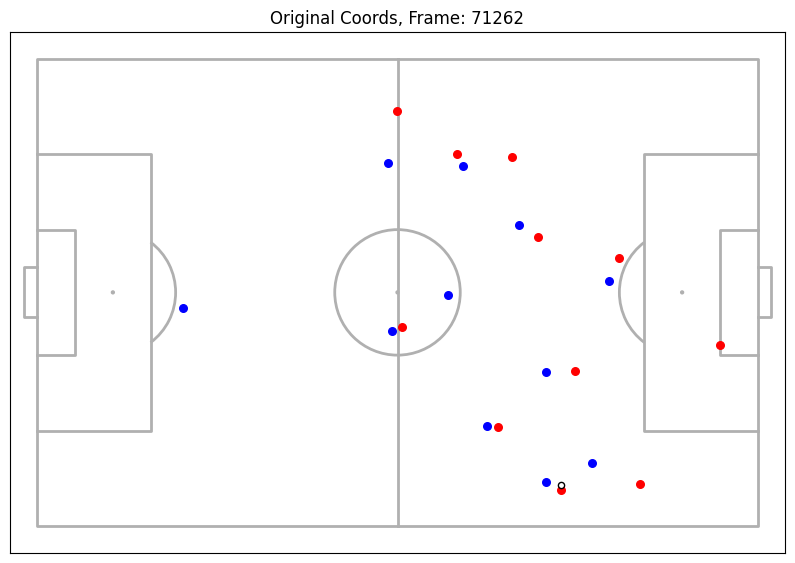

In [83]:
from unxpass import visualizers_made
startFrame = eventcsv[eventcsv['EVENT_ID'] == event_id].iloc[0]['FRAME_NUMBER']
custom_frames = range(startFrame - 50, startFrame + 50)
visualizers_made.get_animation_from_raw(event_id, 1, eventcsv, trackingdf,custom_frames = custom_frames, show = True, add_frames = None, frameskip = 1)

[05/12/25 02:56:40] WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=354771;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=230583;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/matplotlib/legend.py#1323\1323]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

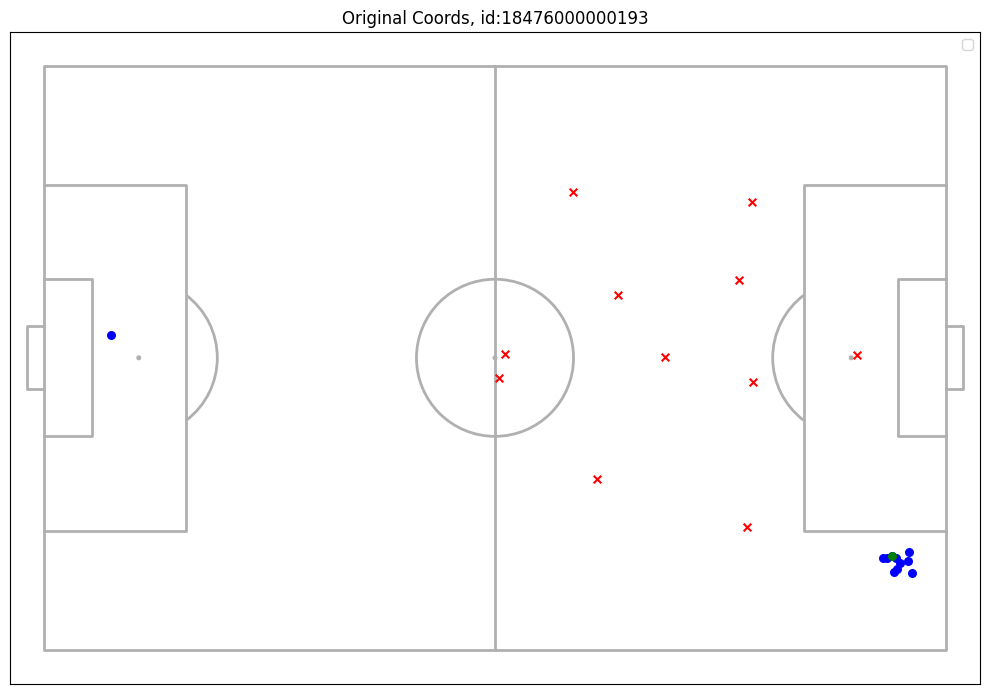

In [ ]:
event_id =  18476000000193
from unxpass import visualizers_made
visualizers_made.visualize_pass_from_raw(event_id, eventcsv,trackingdf)

In [230]:
from unxpass import load_xml
game_id = "DFL-MAT-J03YJD"
eventcsv = load_xml.load_csv_event(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/raw_data/KPI_Merged_all/KPI_MGD_{game_id}.csv")
def checkDeadBall(row, eventcsv):
    if row['SUBTYPE'] not in ['Pass', 'Cross']:#ensure is a legitimate pass
        return -1
    if (eventcsv['FRAME_NUMBER'] == row['FRAME_NUMBER']).sum() > 1:
        framecsv = eventcsv[eventcsv['FRAME_NUMBER'] == row['FRAME_NUMBER']]
        if framecsv['SUBTYPE'].isin(deadBalls).any():
            return -1#ensure also not a deadball situation
    return 1
featPath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/features/features_test"
scores_xg = pd.read_parquet(f"{featPath}/y_scores_xg.parquet")
concedes_xg = pd.read_parquet(f"{featPath}/y_concedes_xg.parquet")
success = pd.read_parquet(f'{featPath}/y_success.parquet')
scores = pd.read_parquet(f'{featPath}/y_scores.parquet')

In [198]:
#eventcsv = eventcsv.set_index(['MUID', 'EVENT_ID'])
eventcsv['FRAME_NUMBER'] = eventcsv['FRAME_NUMBER'].astype(float)
eventcsv = eventcsv.sort_values(by = "FRAME_NUMBER")
eventcsv = eventcsv.reset_index(drop = True)
#action_id = ('DFL-MAT-J03YEM', 18455800000011)
#team = eventcsv.loc[(action_id)]['CUID1']
#vals = eventcsv.loc[action_id:(action_id[0], action_id[1] + 21)]
#vals[(~pd.isna(vals['xG'])) & (vals['CUID1'] != team)]['xG']
#vals['xG']
#
#eventcsv[~pd.isna(eventcsv['xG'])]#
def get_next_n_unique_frames(df, start_idx, nextActs = 10):
    # Get the starting FRAME_NUMBER
    start_frame = df.loc[start_idx, 'FRAME_NUMBER']

    # Slice after the current row
    df_after = df.loc[start_idx + 1:]

    # Get next 10 unique FRAME_NUMBERs after the current one
    next_frames = df_after[df_after['FRAME_NUMBER'] != start_frame]['FRAME_NUMBER'].drop_duplicates().head(nextActs)

    # Filter all rows in df with those 10 FRAME_NUMBERs
    return df[df['FRAME_NUMBER'].isin(next_frames)]
test = get_next_n_unique_frames(eventcsv, 1)
eventcsv[eventcsv['xG'] > 0]

TypeError: '>' not supported between instances of 'str' and 'int'

In [119]:
def getFeats(games):
    index = pd.MultiIndex.from_tuples([], names=['game_id', 'action_id'])
    success = pd.DataFrame(columns = ["success"], index = index)
    scores = pd.DataFrame(columns = ["scores"], index = index)
    concedes = pd.DataFrame(columns = ["concedes"], index = index)
    scores_xg = pd.DataFrame(columns = ["scores_xg"], index = index)
    concedes_xg = pd.DataFrame(columns = ["concedes_xg"], index = index)
    for game_id in games:
        eventcsv = load_xml.load_csv_event(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/raw_data/KPI_Merged_all/KPI_MGD_{game_id}.csv")
        is_kickoff = (eventcsv['SUBTYPE'] == 'Kickoff') | (eventcsv['SUBTYPE'] == 'FinalWhistle')
        kickoffFrames = eventcsv[is_kickoff].index
        for idx, row in eventcsv.iterrows():
            action_id = row['EVENT_ID']
            if checkDeadBall(row, eventcsv) == -1:
                continue
            feats = getFeatsPlay(idx, row, kickoffFrames)
            feats['success'] = row['EVALUATION'] in ['successfullyComplete', 'successful']
            success.loc[(game_id, action_id), "success"] = feats['success']
            scores.loc[(game_id, action_id), "scores"] = feats['scores']
            concedes.loc[(game_id, action_id), "concedes"] = feats['concedes']
            scores_xg.loc[(game_id, action_id), "scores_xg"] = feats['scores_xg']
            concedes_xg.loc[(game_id, action_id), "concedes_xg"] = feats['concedes_xg']
    return success, scores, concedes, scores_xg, concedes_xg
def getFeatsPlay(idx, row, kickoffFrames):
    shots = ['BlockedShot', 'SavedShot', 'SuccessfulShot', 'ShotWide']
    featuresOutput = {"scores": False, "concedes": False, "scores_xg":0, "concedes_xg":0}
    greater_values = [kickoffFrame for kickoffFrame in kickoffFrames if kickoffFrame > idx]
    closest_end = min(greater_values) if greater_values else None
    team = row['CUID1']
    nextidx = min(idx + 11, closest_end)
    nextFrames = eventcsv.loc[idx + 1:nextidx]
    shots = nextFrames[nextFrames['SUBTYPE'].isin(shots)]
    if len(shots) == 0:
        return featuresOutput
    shots['xG'] = shots['xG'].str.replace(",", ".").astype(float)
    offensiveShots = shots[shots['CUID1'] == team]
    featuresOutput["scores_xg"] = 1 - np.prod(1 - offensiveShots['xG'])
    featuresOutput['scores'] = 'SuccessfulShot' in offensiveShots['SUBTYPE']
    defensiveShots = shots[shots['CUID1'] != team]
    featuresOutput["concedes_xg"] = 1 - np.prod(1 - defensiveShots['xG'])
    featuresOutput['concedes'] = 'SuccessfulShot' in defensiveShots['SUBTYPE']
    return featuresOutput
games = [game_id.split("_")[-1].split(".")[0] for game_id in os.listdir("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/raw_data/KPI_Merged_all/")]
games = games[:1]
a,b,c,d,e = getFeats(games)

In [ ]:
eventcsv['SUBTYPE'].unique()
'BlockedShot', 'SavedShot', 'SuccessfulShot', 'ShotWide'

array(['Pass', 'BlockedShot', 'Cross', 'OtherBallAction', 'Air', 'Ground',
       'Foul', 'SuccessfulShot', 'Offside', 'SavedShot', 'Substitution',
       'FinalWhistle', 'ShotWide', 'FairPlay', 'PossessionLossBeforeGoal',
       'Nutmeg', 'ChanceWithoutShot', 'SpectacularPlay',
       'PlayerNotSentOff', 'RefereeBall', 'BallClaiming', 'ThrowIn',
       'Kickoff', 'CornerKick', 'FreeKick', 'GoalKick'], dtype=object)

In [91]:
custom_path = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_Features/Hawkeye_Features_Updated_wSecond"
dataset_test = partial(PassesDataset, path=custom_path)
model = pass_selection_speeds.SoccerMapComponent(
    model=mlflow.pytorch.load_model(
        'runs:/0e64f9978dd04e7cb38602143178d8ce/model', map_location='cpu'
        #'runs:/788ec5a232af46e59ac984d50ecfc1d5/model', map_location='cpu'
    )
)
sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequence_filtered.csv", delimiter = ";")
freeze_frame = pd.read_parquet(f"{custom_path}/x_freeze_frame_360.parquet")
surfaces = model.predict_surface(dataset_test, model_name = "sel")

sel


[05/06/25 19:37:53] INFO     Loading dataset from                                                   ]8;id=986274;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=184035;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\
                             /home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_Features/Ha                
                             wkeye_Features_Updated_wSecond                                                        

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not NoneType

In [80]:
hawkeyeEvents = pd.read_json(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/womens_euro/events/{game}")

In [86]:
sequences[sequences['match_id'] == 3844384]
hawkeyeEvents[hawkeyeEvents['id'] == '74595c4e-2081-401d-b094-eb53d55d00c4']
hawkeyeEvents.loc[439:]

id  index  period  \
439   74595c4e-2081-401d-b094-eb53d55d00c4    440       1   
440   605e7572-7522-4b29-855a-c69fb6eaf63e    441       1   
441   2f964d74-0192-40a3-8f8b-89478118de9b    442       1   
442   7728f0fa-7559-40e8-ad17-703eecc7c017    443       1   
443   cf73e3f7-1e45-41dd-ac03-b8422aa72305    444       1   
...                                    ...    ...     ...   
4345  61ab1d76-e151-45d0-bbe2-d374c30d36c0   4346       4   
4346  71bf5d0b-0d01-45a3-b601-094b7a8120b5   4347       4   
4347  5f848eb4-f9be-4b8e-a0da-c026c9cdd142   4348       4   
4348  699bd4b7-eb9c-417a-87d4-1aeab884e8e6   4349       4   
4349  61d81354-800a-44ed-8ab0-ef962207d1f6   4350       4   

                   timestamp  minute  second  \
439  2025-05-06 00:11:24.837      11      24   
440  2025-05-06 00:11:24.837      11      24   
441  2025-05-06 00:11:29.796      11      29   
442  2025-05-06 00:11:31.248      11      31   
443  2025-05-06 00:11:31.248      11      31   
...                      ...     ...     ...   
4345 2025-05-06 00:18:58.457     123      58   
4346 2025-05-06 00:18:58.611     123      58   
4347 2025-05-06 00:18:58.679     123      58   
4348 2025-05-06 00:19:04.972     124       4   
4349 2025-05-06 00:19:04.972     124       4   

                                     type  possession  \
439   {'id': 42, 'name': 'Ball Receipt*'}          24   
440           {'id': 43, 'name': 'Carry'}          24   
441            {'id': 30, 'name': 'Pass'}          24   
442   {'id': 42, 'name': 'Ball Receipt*'}          24   
443           {'id': 43, 'name': 'Carry'}          24   
...                                   ...         ...   
4345          {'id': 43, 'name': 'Carry'}         244   
4346           {'id': 30, 'name': 'Pass'}         244   
4347           {'id': 6, 'name': 'Block'}         244   
4348       {'id': 34, 'name': 'Half End'}         244   
4349       {'id': 34, 'name': 'Half End'}         244   

                             possession_team  \
439   {'id': 865, 'name': 'England Women's'}   
440   {'id': 865, 'name': 'England Women's'}   
441   {'id': 865, 'name': 'England Women's'}   
442   {'id': 865, 'name': 'England Women's'}   
443   {'id': 865, 'name': 'England Women's'}   
...                                      ...   
4345    {'id': 863, 'name': 'Spain Women's'}   
4346    {'id': 863, 'name': 'Spain Women's'}   
4347    {'id': 863, 'name': 'Spain Women's'}   
4348    {'id': 863, 'name': 'Spain Women's'}   
4349    {'id': 863, 'name': 'Spain Women's'}   

                           play_pattern  ... ball_recovery  clearance dribble  \
439   {'id': 1, 'name': 'Regular Play'}  ...           NaN        NaN     NaN   
440   {'id': 1, 'name': 'Regular Play'}  ...           NaN        NaN     NaN   
441   {'id': 1, 'name': 'Regular Play'}  ...           NaN        NaN     NaN   
442   {'id': 1, 'name': 'Regular Play'}  ...           NaN        NaN     NaN   
443   {'id': 1, 'name': 'Regular Play'}  ...           NaN        NaN     NaN   
...                                 ...  ...           ...        ...     ...   
4345  {'id': 1, 'name': 'Regular Play'}  ...           NaN        NaN     NaN   
4346  {'id': 1, 'name': 'Regular Play'}  ...           NaN        NaN     NaN   
4347  {'id': 1, 'name': 'Regular Play'}  ...           NaN        NaN     NaN   
4348  {'id': 1, 'name': 'Regular Play'}  ...           NaN        NaN     NaN   
4349  {'id': 1, 'name': 'Regular Play'}  ...           NaN        NaN     NaN   

     interception miscontrol foul_committed block 50_50 substitution  \
439           NaN        NaN            NaN   NaN   NaN          NaN   
440           NaN        NaN            NaN   NaN   NaN          NaN   
441           NaN        NaN            NaN   NaN   NaN          NaN   
442           NaN        NaN            NaN   NaN   NaN          NaN   
443           NaN        NaN            NaN   NaN   NaN          NaN   
...           ...        ...            ...   ...   ...        

In [2]:
import json
def getTeamDictGks(match_path):
    with open(match_path, 'r') as file:
        match_data = json.load(file)
    team_dict = {player['id'] : player['team_id'] for player in match_data['players']}
    gks = [player['id'] for player in match_data['players'] if player["player_role"]['id'] == 0]
    return team_dict, gks
sc_events = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/733681_Germany_Spain/733681_dynamic_events.csv")
tracking = pd.read_json("/home/lz80/un-xPass/unxpass/steffen/733681_Germany_Spain/733681_tracking_extrapolated.jsonl", lines = True)
team_dict, gks = getTeamDictGks("/home/lz80/un-xPass/unxpass/steffen/733681_Germany_Spain/733681_match.json")

In [22]:
tracking[tracking['frame'] == 15560]
tracking[(tracking['player_data'].apply(len) > 0) & (tracking['frame'] >= 15555)].sort_values(by = "frame", ascending = True)

frame               timestamp  period  \
15556  15556 2025-05-05 00:25:49.600     1.0   
15557  15557 2025-05-05 00:25:49.700     1.0   
15558  15558 2025-05-05 00:25:49.800     1.0   
15559  15559 2025-05-05 00:25:49.900     1.0   
15560  15560 2025-05-05 00:25:50.000     1.0   
...      ...                     ...     ...   
56012  56012 2025-05-05 01:33:01.200     2.0   
56013  56013 2025-05-05 01:33:01.300     2.0   
56014  56014 2025-05-05 01:33:01.400     2.0   
56015  56015 2025-05-05 01:33:01.500     2.0   
56016  56016 2025-05-05 01:33:01.600     2.0   

                                               ball_data  \
15556  {'x': 7.8, 'y': -18.76, 'z': 0.21, 'is_detecte...   
15557  {'x': 7.61, 'y': -17.98, 'z': 0.21, 'is_detect...   
15558  {'x': 7.52, 'y': -17.34, 'z': 0.23, 'is_detect...   
15559  {'x': 7.48, 'y': -16.63, 'z': 0.22, 'is_detect...   
15560  {'x': 7.35, 'y': -15.57, 'z': 0.15, 'is_detect...   
...                                                  ...   
56012  {'x': 14.94, 'y': -0.97, 'z': 3.49, 'is_detect...   
56013  {'x': 16.64, 'y': -0.13, 'z': 3.16, 'is_detect...   
56014  {'x': 18.27, 'y': 0.65, 'z': 2.87, 'is_detecte...   
56015  {'x': 19.42, 'y': 1.03, 'z': 2.62, 'is_detecte...   
56016  {'x': 20.45, 'y': 1.31, 'z': 2.24, 'is_detecte...   

                                      possession  \
15556  {'player_id': None, 'group': 'home team'}   
15557  {'player_id': None, 'group': 'home team'}   
15558  {'player_id': None, 'group': 'home team'}   
15559  {'player_id': None, 'group': 'home team'}   
15560  {'player_id': None, 'group': 'home team'}   
...                                          ...   
56012         {'player_id': None, 'group': None}   
56013         {'player_id': None, 'group': None}   
56014         {'player_id': None, 'group': None}   
56015         {'player_id': None, 'group': None}   
56016         {'player_id': None, 'group': None}   

                                image_corners_projection  \
15556  {'x_top_left': None, 'y_top_left': None, 'x_bo...   
15557  {'x_top_left': None, 'y_top_left': None, 'x_bo...   
15558  {'x_top_left': None, 'y_top_left': None, 'x_bo...   
15559  {'x_top_left': -9.74, 'y_top_left': 18.2, 'x_b...   
15560  {'x_top_left': -10.32, 'y_top_left': 19.86, 'x...   
...                                                  ...   
56012  {'x_top_left': 3.76, 'y_top_left': 37.5, 'x_bo...   
56013  {'x_top_left': 5.39, 'y_top_left': 37.5, 'x_bo...   
56014  {'x_top_left': 7.67, 'y_top_left': 37.5, 'x_bo...   
56015  {'x_top_left': 9.31, 'y_top_left': 37.5, 'x_bo...   
56016  {'x_top_left': 11.64, 'y_top_left': 37.5, 'x_b...   

                                             player_data  
15556  [{'x': -36.17, 'y': -3.17, 'player_id': 22438,...  
15557  [{'x': -36.27, 'y': -3.17, 'player_id': 22438,...  
15558  [{'x': -36.36, 'y': -3.17, 'player_id': 22438,...  
15559  [{'x': -36.45, 'y': -3.19, 'player_id': 22438,...  
15560  [{'x': -36.53, 'y': -3.2, 'player_id': 22438, ...  
...                                                  ...  
56012  [{'x': -36.19, 'y': -0.98, 'player_id': 22453,...  
56013  [{'x': -36.03, 'y': -0.92, 'player_id': 22453,...  
56014  [{'x': -35.87, 'y': -0.86, 'player_id': 22453,...  
56015  [{'x': -35.7, 'y': -0.8, 'player_id': 22453, '...  
56016  [{'x': -35.51, 'y': -0.73, 'player_id': 22453,...  

[30824 rows x 7 columns]

In [170]:
from matplotlib.patches import Polygon
def visualize_sc_pass(event_id, event, tracking, team_dict, team_cols, *,
                      title=None, ax=None, surfaces=None, custom_frame=None):
    event_frame = event[event['event_id'] == event_id].iloc[0]['frame_start']
    if custom_frame is not None:
        event_frame = custom_frame
    frame = tracking[tracking["frame"] == event_frame].iloc[0]
    ball = frame["ball_data"]
    player = frame["player_data"]
    poly = frame["image_corners_projection"]
    if poly['x_top_left'] is not None:
        points = [
        (poly['x_top_left'] + 52.5, poly['y_top_left'] + 34),
        (poly['x_top_right'] + 52.5, poly['y_top_right'] + 34),
        (poly['x_bottom_right'] + 52.5, poly['y_bottom_right'] + 34),
        (poly['x_bottom_left'] + 52.5, poly['y_bottom_left'] + 34),
    ]
    title = f"Frame {event_frame}"
    start_x, start_y = ball['x'], ball['y']
    team_1, team_2 = set(team_dict.values())
    # Create a pitch with a custom origin (0, 0) at the center circle
    start_x = start_x + 52.5
    start_y = (start_y + 34)
    pitch = mplsoccer.pitch.Pitch(pitch_type='custom', 
                  half=False,         # Show only half the pitch (positive quadrant)
                  pitch_length=105,   # Length of the pitch (in meters)
                  pitch_width=68,     # Width of the pitch (in meters)
                  goal_type='box',
                  axis=True)          # Show axis for coordinates
    
    # Create a figure
    if ax is None:
        fig, ax = pitch.draw(figsize=(10, 7))
    else:
        ax.clear()
        pitch.draw(ax=ax)
    team_1_x = [play['x'] + 52.5 for play in player if team_dict[play['player_id']] == team_1]
    team_1_y = [play['y'] + 34 for play in player if team_dict[play['player_id']] == team_1]
    team_2_x = [play['x'] + 52.5 for play in player if team_dict[play['player_id']] == team_2]
    team_2_y = [play['y'] + 34 for play in player if team_dict[play['player_id']] == team_2]
    pitch.scatter(team_1_x, team_1_y, c=team_cols[team_1][0], s=30, ax=ax, marker = team_cols[team_1][1])
    pitch.scatter(team_2_x, team_2_y, c=team_cols[team_2][0], s=30, ax=ax, marker = team_cols[team_2][1])
    if poly['x_top_left'] is not None:
        polygon = Polygon(points, closed=True, facecolor='gray', alpha=0.5)
        ax.add_patch(polygon)
    pitch.scatter([start_x], [start_y], c="w", ec = "k", s=20, ax=ax)
    for play in player:
        pid = play['player_id']
        label_x = play['x'] + 52.5 + 0.5  # shift label slightly to the right
        label_y = play['y'] + 34 + 0.5
        ax.text(label_x, label_y, str(pid), fontsize=8, color='black', ha='left', va='bottom')
    if surfaces is not None:
        surface = surfaces[event_number]
        surface_kwargs = {"interpolation":"bilinear", "vmin": None, "vmax": None, "cmap": "Greens"}
        ax.imshow(surface, extent=[0.0, 105.0, 0.0, 68.0], origin="lower", **surface_kwargs)
    # Set labels
    ax.set_title(title)
def animate_sc_vals(event_ids, event, tracking, team_dict, team_cols, surfaces=None, title=None, interval=200, custom_frames = None):
    """ 
    Animate frames from skillcorner data
    event_id - list of "events" to animate - in our case, dummy events representing frames
    tracking - skillcorner tracking df
    event - skillcorner event df
    team_dict - dictionary mapping player : team
    team_cols - dictionary mapping team : [color team, symbol team]
    surfaces - dictionary mapping [frame : surface]
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    if custom_frames is not None:
        def update(frame):#kinda hacky way to do this but oh well
            visualize_sc_pass(
                event_id=event_id,
                event=event,
                tracking=tracking,
                team_dict=team_dict,
                team_cols=team_cols,
                title=title,
                ax=ax,
                surfaces=surfaces,
                custom_frame=frame
            )

        ani = FuncAnimation(fig, update, frames=custom_frames, repeat=False, interval=interval)
    else:
        def update(event_id):
            visualize_sc_pass(event_id, event, tracking, team_dict, team_cols, surfaces, title, custom_frame = None)
        ani = FuncAnimation(fig, update, frames=event_ids, repeat=False, interval=interval)
    return ani
import mplsoccer
def get_player_xy(row):
    for player in row['player_data']:
        if player['player_id'] == row['player_id']:
            return [player['x'], player['y']]
    return [None, None] # or np.nan
def compute_distances(row):
    a = np.array(row['ball'])
    b = np.array(row['passer_loc'])
    return np.linalg.norm(a - b).tolist()
def preProcessPass(events, tracking):
    passes = events[events["end_type_id"] == 1][['match_id','event_id', 'period', 'frame_start', 'frame_end',  'attacking_side', 'player_id', 'team_id',"player_targeted_id"]]
    tracking_dropped = tracking.drop(columns = ["period"])#hopefully only have to merge on frame, not period too
    passes = pd.merge(passes, tracking_dropped, left_on = "frame_end", right_on = "frame")
    passes['ball'] = passes['ball_data'].apply(lambda x: [x['x'], x['y']])
    passes['passer_loc'] = passes.apply(lambda x: get_player_xy(x), axis = 1)
    passes['distances'] = passes.apply(lambda x: compute_distances(x), axis=1)
    return passes[passes['distances'] < 5]#cutting out distance issues
passes = preProcessPass(sc_events, tracking)

[05/05/25 22:04:46] INFO     Animation.save using <class 'matplotlib.animation.HTMLWriter'>       ]8;id=275085;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/matplotlib/animation.py\animation.py]8;;\:]8;id=417523;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/matplotlib/animation.py#1052\1052]8;;\

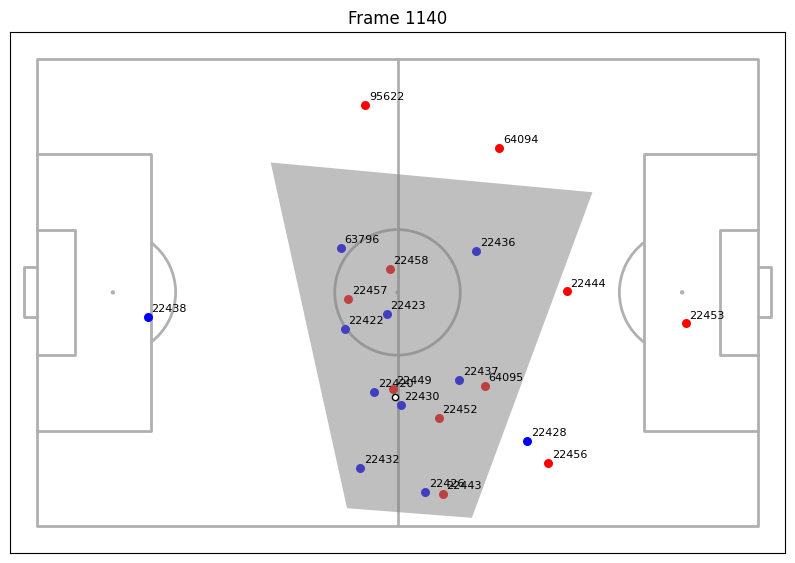

In [134]:
passes = preProcessPass(sc_events, tracking)
#add check to make sure recipient data is correct - if location too far - drop
event = passes.iloc[18]
event_id = event["event_id"]
start_frame = event["frame_start"]
end_frame = event["frame_end"]
team_1, team_2 = set(team_dict.values())
team_cols = {team_1: ['b', 'o'], team_2:['r', 'o']}
custom_frames = list(range(end_frame , end_frame + 20))
from matplotlib.animation import FuncAnimation
ani = animate_sc_vals(["8_1"], sc_events, tracking, team_dict, team_cols, surfaces=None, title=None, interval=200, custom_frames = custom_frames)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [154]:
passes

match_id event_id  period  frame_start  frame_end  period attacking_side  \
0      733681      8_0       1           63         63       1  right_to_left   
1      733681      8_1       1           77         91       1  right_to_left   
2      733681      8_3       1          258        258       1  right_to_left   
3      733681      8_4       1          269        281       1  right_to_left   
4      733681      8_7       1          644        644       1  right_to_left   
..        ...      ...     ...          ...        ...     ...            ...   
939    733681   8_1056       2        55897      55897       2  left_to_right   
940    733681   8_1057       2        55917      55917       2  left_to_right   
941    733681   8_1058       2        55924      55924       2  left_to_right   
942    733681   8_1059       2        55942      55942       2  left_to_right   
943    733681   8_1060       2        55954      55964       2  left_to_right   

     player_id  team_id  player_targeted_id  frame               timestamp  \
0        22458      796             64095.0     63 2025-05-05 00:00:00.300   
1        64095      796             22457.0     91 2025-05-05 00:00:03.100   
2        22456      796             22444.0    258 2025-05-05 00:00:19.800   
3        22444      796             64094.0    281 2025-05-05 00:00:22.100   
4        22457      796             22443.0    644 2025-05-05 00:00:58.400   
..         ...      ...                 ...    ...                     ...   
939      64094      796             64104.0  55897 2025-05-05 01:32:49.700   
940      64104      796             22458.0  55917 2025-05-05 01:32:51.700   
941      22458      796             64094.0  55924 2025-05-05 01:32:52.400   
942      64094      796             22444.0  55942 2025-05-05 01:32:54.200   
943      22444      796             68199.0  55964 2025-05-05 01:32:56.400   

                                             ball_data  \
0    {'x': 0.8200000000000001, 'y': -0.5, 'z': 0.23...   
1    {'x': 14.41, 'y': -1.18, 'z': 0.34, 'is_detect...   
2    {'x': -9.17, 'y': 0.21, 'z': 0.15, 'is_detecte...   
3    {'x': -14.67, 'y': 16.23, 'z': 0.11, 'is_detec...   
4    {'x': -46.23, 'y': 6.67, 'z': 1.45, 'is_detect...   
..                                                 ...   
939  {'x': -12.51, 'y': -21.26, 'z': 2.530000000000...   
940  {'x': -8.43, 'y': -25.59, 'z': 1.3599999999999...   
941  {'x': -6.17, 'y': -24.98, 'z': 1.8, 'is_detect...   
942  {'x': -14.52, 'y': -24.36, 'z': 0.25, 'is_dete...   
943  {'x': -18.88, 'y': -16.08, 'z': 0.09, 'is_dete...   

                                     possession  \
0     {'player_id': None, 'group': 'away team'}   
1     {'player_id': None, 'group': 'away team'}   
2    {'player_id': 22456, 'group': 'away team'}   
3    {'player_id': 22444, 'group': 'away team'}   
4     {'player_id': None, 'group': 'away team'}   
..                                          ...   
939   {'player_id': None, 'group': 'away team'}   
940   {'player_id': None, 'group': 'away team'}   
941   {'player_id': None, 'group': 'away team'}   
942  {'player_id': 64094, 'group': 'away team'}   
943  {'player_id': 22444, 'group': 'away team'}   

                              image_corners_projection  \
0    {'x_top_left': -38.05, 'y_top_left': 37.5, 'x_...   
1    {'x_top_left': -19.01, 'y_top_left': 37.5, 'x_...   
2    {'x_top_left': -57.5, 'y_top_left': 37.5, 'x_b...   
3    {'x_top_left': -51.15, 'y_top_left': 37.5, 'x_...   
4    {'x_top_left': -95.21, 'y_top_left': 37.5, 'x_...   
..                                                 ...   
939  {'x_top_left': -36.6, 'y_top_left': 20.29, 'x_...   
940  {'x_top_left': -36.58, 'y_top_left': 12.22, 'x...   
941  {'x_top_left': -34.1, 'y_top_left': 13.13, 'x_...   
942  {'x_top_left': -39.44, 'y_top_left': 13.37, 'x...   
943  {'x_top_left': -45.22, 'y_top_left': 25.83, 'x...   

                                           player_data  \
0    [{'x': -39.83, 'y': 0.01,

In [180]:
#.1 fps
#{"actor":false,"goalkeeper":false,"player":"DFL-OBJ-002FWZ","recipient":false,"teammate":true,"x":39.44,
# "x_velo":-0.5000000000000071,"y":12.939999999999998,"y_velo":-0.5999999999999872}
def getBallData(row, tracking, periodBounds, frameDiff = 5):
    frame = row['frame']
    periodBound = periodBounds[int(row['period'])]
    orientation = 1 if row['attacking_side'] == 'left_to_right' else -1
    lowerBound = min(frameDiff, frame - periodBound[0])#ensure always within half bounds
    upperBound = min(frameDiff, periodBound[1] - frame)
    timeElapsed = 2 * (lowerBound + upperBound) * .1
    ballPrevFive = tracking[tracking['frame'] == frame - frameDiff].iloc[0]['ball_data']
    ballPostFive = tracking[tracking['frame'] == frame + frameDiff].iloc[0]['ball_data']
    ballData = tracking[tracking['frame'] == frame].iloc[0]['ball_data']
    speed_x = (ballPostFive['x'] - ballPrevFive['x']) / timeElapsed * orientation
    speed_y = (ballPostFive['y'] - ballPrevFive['y']) / timeElapsed
    start_x_a0 = (105 * ((orientation + 1) / 2)) - (ballData['x'] + 52.5)
    start_y_a0 = ballData['y'] + 34
    return pd.Series({"speedx_a02":speed_x, "speed_y_a02":speed_y, 
    "start_x_a0":start_x_a0, "start_y_a0":start_y_a0,
    "end_x_a0":52.5, "end_y_a0":34})#dummy to set to halfLine
def getPlayerFrame(row, tracking, goalkeepers, team_dict,periodBounds, frameDiff = 5):
    #need to add 52.5, 34 and then flip if needed so that always l to r, -1 if l to r, 1 if r to l
    frame = row['frame']
    actor = row['player_id']
    periodBound = periodBounds[int(row['period'])]
    team = row['team_id']
    target = row['player_targeted_id']
    orientation = 1 if row['attacking_side'] == 'left_to_right' else -1
    lowerBound = min(frameDiff, frame - periodBound[0])#ensure always within half bounds
    upperBound = min(frameDiff, periodBound[1] - frame)
    timeElapsed = 2 * (lowerBound + upperBound) * .1
    playerPrevFive = tracking[tracking['frame'] == frame - lowerBound].iloc[0]['player_data']
    playerPostFive = tracking[tracking['frame'] == frame + upperBound].iloc[0]['player_data']
    playerData = tracking[tracking['frame'] == frame].iloc[0]['player_data']
    playerFrames = []
    for player in playerPrevFive:
        player_dict = {}
        player_id = player['player_id']
        playerPost = [playerPost for playerPost in playerPostFive if playerPost['player_id'] == player_id][0]
        #ensure no errors if player not avaliable 10 frames later
        player_dict['x_velo'] = ((player['x'] - playerPost['x']) / (timeElapsed)) * orientation
        player_dict['y_velo']  = (player['y'] - playerPost['y']) / (timeElapsed)
        player_dict['x'] = (105 * ((orientation + 1) / 2)) - (player['x'] + 52.5)#map -1 to 0 and 1 to 1
        player_dict['y'] = player['y'] + 34
        player_dict['actor'] = player_id == actor
        player_dict['recipient'] = player_dict['actor']#
        player_dict['teammate'] = team_dict[player_id] == team
        player_dict['goalkeeper'] = player_id in goalkeepers
        playerFrames.append(player_dict)
    return playerFrames
def getSkillCornerFF(frame, game_id, event_id, tracking, actor, team, goalkeepers, orientation, team_dict, period, bounds, framesAfter = 10):
    #get ff on an event level
    periodBound = bounds[period]
    framesAfter = min(periodBound[1] - frame, framesAfter)
    trackingFrames = tracking[(tracking['frame'] >= frame) & (tracking['frame'] <= frame + framesAfter)]
    #check for starts annd ends
    ids = [f"{event_id}-{index}" for index in range(framesAfter + 1)]
    trackingFrames = trackingFrames.sort_values(by = "frame")#insurance to make sure everything is in order, ascending
    trackingFrames['action_id'] = ids
    trackingFrames['game_id'] = game_id
    trackingFrames['freeze_frame_360_a0'] = trackingFrames.apply(lambda x: getPlayerFrame(x, tracking, actor, team, goalkeepers, orientation, team_dict, periodBound), axis = 1)
    trackingFrames[["start_x_a0", "start_y_a0", "speed_x_a02", "speed_y_a02","end_x_a0", "end_y_a0"]] = trackingFrames.apply(lambda x: getBallData(x, tracking, orientation, periodBound), axis = 1)
    trackingFrames = trackingFrames.set_index(['game_id', 'action_id'])
    freezeFrame = trackingFrames['freeze_frame_360_a0']
    startLoc = trackingFrames[["start_x_a0", "start_y_a0"]]
    endLoc = trackingFrames[['end_x_a0', 'end_y_a0']]
    speed = trackingFrames[['speed_x_a02', 'speed_y_a02']]
    return freezeFrame, startLoc, endLoc, speed
def getAllSkillCornerFF(tracking, passes, goalkeepers, team_dict):
    periodBounds = tracking.groupby('period').agg(
        end=('frame', np.max),
        start=('frame', np.min))
    periodDict = {period: [row['start'], row['end']] for period, row in periodBounds.to_dict('index').items()}
    passes['freeze_frame_360_a0'] = passes.apply(lambda row: getPlayerFrame(row, tracking, goalkeepers, team_dict,periodDict, frameDiff = 5), axis = 1)
    passes[["start_x_a0", "start_y_a0", "speed_x_a02", "speed_y_a02","end_x_a0", "end_y_a0"]] = passes.apply(lambda row: getBallData(row, tracking, periodDict, frameDiff = 5), axis = 1)
    passes = passes.set_index(['game_id', 'action_id'])
    freezeFrame = passes['freeze_frame_360_a0']
    startLoc = passes[["start_x_a0", "start_y_a0"]]
    endLoc = passes[['end_x_a0', 'end_y_a0']]
    speed = passes[['speed_x_a02', 'speed_y_a02']]
    return freezeFrame, startLoc, endLoc, speed
ffs, starts, ends, speeds = getAllSkillCornerFF(tracking, passes, gks, team_dict)

match_id                                                               733681
event_id                                                                  8_0
period                                                                      1
frame_start                                                                63
frame_end                                                                  63
attacking_side                                                  right_to_left
player_id                                                               22458
team_id                                                                   796
player_targeted_id                                                    64095.0
frame                                                                      63
timestamp                                          2025-05-05 00:00:00.300000
ball_data                   {'x': 0.8200000000000001, 'y': -0.5, 'z': 0.23...
possession                          {'player_id': None, 'group':

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [234]:
speeds

speed_x_a02  speed_y_a02
game_id action_id                          
733681  8_1-0           -67.46        30.47
        8_1-1           -67.55        30.57
        8_1-2           -67.53        30.77
        8_1-3           -67.51        30.97
        8_1-4           -67.52        31.16
...                        ...          ...
        8_1060-6         72.11        17.30
        8_1060-7         72.07        17.34
        8_1060-8         72.04        17.43
        8_1060-9         71.88        17.60
        8_1060-10        71.38        17.92

[7436 rows x 2 columns]

[05/04/25 21:33:40] INFO     Animation.save using <class 'matplotlib.animation.HTMLWriter'>       ]8;id=28727;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/matplotlib/animation.py\animation.py]8;;\:]8;id=934725;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/matplotlib/animation.py#1052\1052]8;;\

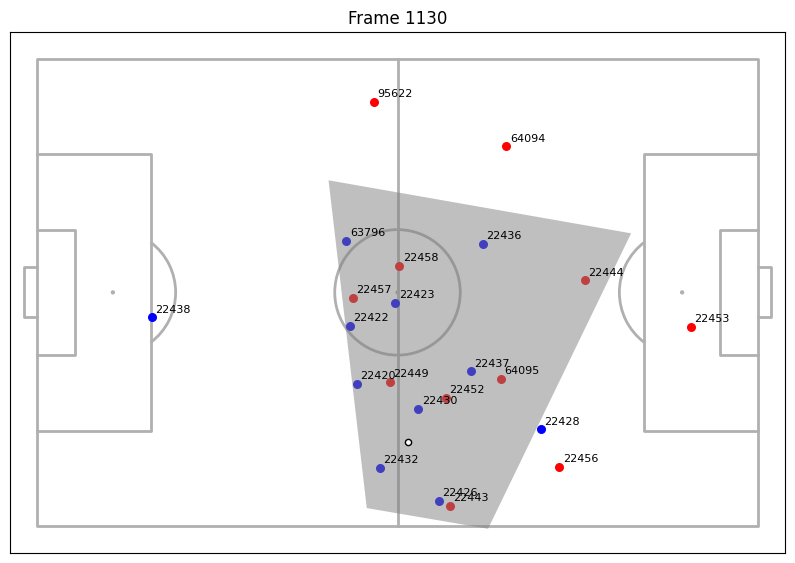

In [152]:
import mplsoccer
#add check to make sure recipient data is correct - if location too far - drop
tracking.index = tracking["frame"]
reception = sc_events[sc_events["start_type"] == "pass_reception"].iloc[14]
event_id = reception["event_id"]
start_frame = reception["frame_start"]
team_1, team_2 = set(team_dict.values())
team_cols = {team_1: ['b', 'o'], team_2:['r', 'o']}
custom_frames = list(range(start_frame - 10, start_frame + 5))
from matplotlib.animation import FuncAnimation
ani = animate_sc_vals(["8_1"], sc_events, tracking, team_dict, team_cols, surfaces=None, title=None, interval=200, custom_frames = custom_frames)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
#need to parse ball and player speed, freeze frame, end and start location for receptions
#pass reception


event_id                                 8_1
index                                      1
match_id                              733681
frame_start                               77
frame_end                                 91
                                       ...  
is_player_possession_start_matched      True
is_player_possession_end_matched        True
is_previous_pass_matched                True
is_pass_reception_matched               True
fully_extrapolated                     False
Name: 1, Length: 237, dtype: object

In [21]:
from unxpass import visualizers_made
game_id = "DFL-MAT-J03YE3"
event, tracking = visualizers_made.animationHelper(game_id)
from unxpass.Scripts import add_speed
receipts = add_speed.getReceipts(tracking, event)

In [28]:
def getClosestFrame(row, tracking, angle, end_frame):
    if row["SUBTYPE"] != "Pass" and row['SUBTYPE'] != "Cross":
        print("not pass")
        return row["RECFRM"]#if not pass / cross
    if not pd.isna(row["RECFRM"]) and abs(row["RECFRM"] - row["FRAME_NUMBER"]) > 5:
        print("already has receipt")
        return row["RECFRM"]#if already has receipt frame from event data
    #if row['EVALUATION'] == "unsuccessful":#if unsuccessful, use 20 degree method
        
    if pd.isna(row["PUID2"]) or row["EVALUATION"] == "unsuccessful":
        
        #if we don't know recipient or the evaluation is false
        angleStartFrame = add_speed.getAngleFrames(row, angle)
        if abs(angleStartFrame - row["FRAME_NUMBER"]) < (2 / .04):
            print("angle")
            return angleStartFrame#check if within 2 seconds
        if pd.isna(row["PUID2"]):
            print("added 50")
            return row["FRAME_NUMBER"] + (2/.04) #error case to be checked, essentially - no recipient or good angle frame
    #if we know recipient, find time when recipient is closest:
    print("player pos")
    startFrame = float(row["FRAME_NUMBER"])
    endFrame =  end_frame
    if pd.isna(endFrame):#very specific edge case where last pass is also no receiver and no other events
        endFrame = startFrame + 80
    if abs(startFrame - endFrame) < 5:
        endFrame = endFrame + 80  # Adjust endFrame if too close
    player = row["PUID2"]
    
    between_condition = f"N > {startFrame} and N < {endFrame}"
    player_query = f"{between_condition} and PersonId == @player"
    ball_query = f"{between_condition} and TeamId == 'BALL'"
    
    player_locs = tracking.query(player_query)[["N", "X", "Y"]].rename(columns={"X": "Player_X", "Y": "Player_Y"})
    ball_locs = tracking.query(ball_query)[["N", "X", "Y"]].rename(columns={"X": "Ball_X", "Y": "Ball_Y"})

    all_locs = player_locs.merge(ball_locs, on="N")#merge player and ball 
    
    if all_locs.empty:
        return float(row["NEXT_FRAME"])
    
    # Calculate squared distance
    all_locs["DistanceSq"] = (all_locs["Player_X"] - all_locs["Ball_X"])**2 + (all_locs["Player_Y"] - all_locs["Ball_Y"])**2
    print(all_locs)
    # Get frame with minimum squared distance
    frame = all_locs.loc[all_locs["DistanceSq"].idxmin()]["N"]
    return frame
e_id = 18453900000779
idx = receipts[receipts["EVENT_ID"] == e_id].index[0]
n_map = add_speed.map_n_event(tracking, event)#generates mapping between frames and events
angles = add_speed.getAngleChangeFromStart(tracking, n_map) 
print(receipts[receipts["EVENT_ID"] == e_id]["NEXT_FRAME"].values[0])
getClosestFrame(event.loc[idx], tracking, angles, end_frame = receipts[receipts["EVENT_ID"] == e_id]["NEXT_FRAME"].values[0])

100055.0
already has receipt


100045.0

In [26]:
#event = event.sort_values(by = "FRAME_NUMBER")
eidx = event[event['EVENT_ID'] == e_id].iloc[0]["FRAME_NUMBER"]
receipts = receipts.sort_values(by = "FRAME_NUMBER")
#
eventdf = event.copy()
eventdf = eventdf.sort_values(by=["FRAME_NUMBER", "RECFRM"], na_position="last")
eventdf["NEXT_FRAME"] = eventdf["FRAME_NUMBER"].shift(-1).fillna(method='bfill')
eventdf.loc[eventdf["NEXT_FRAME"] == eventdf["FRAME_NUMBER"], "NEXT_FRAME"] = np.nan
eventdf["NEXT_FRAME"] = eventdf["NEXT_FRAME"].fillna(method='bfill')
eventdf = eventdf.sort_values(by = "FRAME_NUMBER")
eventdf.loc[abs(eventdf["NEXT_FRAME"] - eventdf["FRAME_NUMBER"]) > 300, "NEXT_FRAME"] = eventdf.loc[abs(eventdf["NEXT_FRAME"] - eventdf["FRAME_NUMBER"]) > 300, "FRAME_NUMBER"]
eventdf[eventdf["FRAME_NUMBER"] >= eidx]
#receipts[receipts["FRAME_NUMBER"] >= eidx]

EVENT_ID            MUID  MATCH_DAY           PUID1  \
3     18453900000009  DFL-MAT-J03YE3          2  DFL-OBJ-0027BI   
4     18453900000010  DFL-MAT-J03YE3          2  DFL-OBJ-0028CO   
5     18453900000011  DFL-MAT-J03YE3          2  DFL-OBJ-0026TT   
6     18453900000012  DFL-MAT-J03YE3          2  DFL-OBJ-0028CO   
7     18453900000013  DFL-MAT-J03YE3          2  DFL-OBJ-0028RZ   
...              ...             ...        ...             ...   
1510  18453900001570  DFL-MAT-J03YE3          2  DFL-OBJ-J01B8N   
1514  18453900001574  DFL-MAT-J03YE3          2  DFL-OBJ-J00ZZ3   
1515  18453900001575  DFL-MAT-J03YE3          2  DFL-OBJ-0026TT   
1506  18453900001566  DFL-MAT-J03YE3          2  DFL-OBJ-002G1W   
1516  18453900001577  DFL-MAT-J03YE3          2             NaN   

               Player1  SHIRT_NUMBER1           CUID1              Club1  \
3        Niklas Dorsch             30  DFL-CLU-000010        FC Augsburg   
4          Finn Dahmen              1  DFL-CLU-000010        FC Augsburg   
5       Felix Uduokhai             19  DFL-CLU-000010        FC Augsburg   
6          Finn Dahmen              1  DFL-CLU-000010        FC Augsburg   
7             M. Bauer             23  DFL-CLU-000010        FC Augsburg   
...                ...            ...             ...                ...   
1510  Ryan Gravenberch             38  DFL-CLU-00000G  FC Bayern München   
1514        Harry Kane              9  DFL-CLU-00000G  FC Bayern München   
1515    Felix Uduokhai             19  DFL-CLU-000010        FC Augsburg   
1506     Mads Pedersen              3  DFL-CLU-000010        FC Augsburg   
1516               NaN              0             NaN                NaN   

     Club1_Three_Letter_Code           PUID2  ... PossAng  \
3                        FC   DFL-OBJ-0028CO  ...       0   
4                        FC   DFL-OBJ-0026TT  ...   39,29   
5                        FC   DFL-OBJ-0028CO  ...   46,43   
6                        FC   DFL-OBJ-0028RZ  ...   46,43   
7                        FC   DFL-OBJ-0028CO  ...       0   
...                      ...             ...  ...     ...   
1510                     FC   DFL-OBJ-J00ZZ3  ...      25   
1514                     FC              NaN  ...     NaN   
1515                     FC              NaN  ...     NaN   
1506                     FC              NaN  ...     NaN   
1516                     NaN             NaN  ...     NaN   

      Dis_nearest_opp_rec Dist_of_pass Nearest_Defender_to_passing_lane  \
3                   21,59        27,27                             5,18   
4                   13,79        17,02                            12,65   
5                   16,34        14,88                             9,78   
6                   15,57         22,6                             7,76   
7                   21,83        24,48                             3,95   
...                   ...          ...                              ...   
1510                 3,75        10,78                             1,16   
1514                  NaN          NaN                              NaN   
1515                  NaN          NaN                              NaN   
1506                  NaN          NaN                              NaN   
1516                  NaN          NaN                              NaN   

     Angle_of_pass  OneTouch Time_of_Possesion BlockProb Opp_Players_in_path  \
3           169,22       0.0              2,36         0                 2.0   
4            87,34       0.0              1,64         0                 0.0   
5           106,44       0.0              1,52         0                 1.0   
6            76,23       0.0              4,56         0                 2.0   
7           138,13       0.0              3,24         0                 1.0   
...            ...       ...               ...       ...                 ...   
1510        124,57       0.0              2,36         0                 3.0   
1514           NaN  

In [140]:
nframe = tracking[tracking["N"] == eidx]
nframe[(nframe["PersonId"] == "DFL-OBJ-00266E") | (nframe["TeamId"] == "BALL") ]

GameSection         MatchId          TeamId        PersonId         N  \
2179038  secondHalf  DFL-MAT-J03YDZ  DFL-CLU-000018  DFL-OBJ-00266E  163190.0   
3473105  secondHalf  DFL-MAT-J03YDZ            BALL  DFL-OBJ-0000XT  163190.0   

                                     T      X      Y  
2179038  2023-08-19T15:19:44.920+00:00  37.06 -10.29  
3473105  2023-08-19T15:19:44.920+00:00  34.28  -9.89

In [200]:
def getPassdxdy(frame, tracking):
    end_frame = frame + 10
    ball = tracking[tracking['TeamId'] == 'BALL'].copy()
    ball['N'] = ball['N'].astype(float)
    ball['X'] = ball['X'].astype(float)
    ball['Y'] = ball['Y'].astype(float)
    start = ball.loc[ball['N'] == frame, ["X", "Y"]].values[0]
    end = ball.loc[ball['N'] == end_frame, ["X", "Y"]].values[0]
    return start[0] - end[0], start[1] - end[1]
getPassdxdy(10005, tracking)

(6.800000000000001, -0.8499999999999999)

In [208]:
def getAngleChange(tracking, fb = 5):
    ball_data_df = tracking[tracking['TeamId'] == 'BALL'].copy()
    ball_data_df['N'] = ball_data_df['N'].astype(float)
    ball_data_df['X'] = ball_data_df['X'].astype(float)
    ball_data_df['Y'] = ball_data_df['Y'].astype(float)
    ball_data_df = ball_data_df.sort_values(by = 'N')
    ball_data_df['dx'] = ball_data_df['X'] - ball_data_df.groupby('GameSection')['X'].shift(fb)
    ball_data_df['dy'] = ball_data_df['Y'] -  ball_data_df.groupby('GameSection')['Y'].shift(fb)
    ball_data_df['magnitude'] = np.sqrt(ball_data_df['dx']**2 + ball_data_df['dy']**2)
    ball_data_df['prev_dx'] = ball_data_df['dx'].shift(-fb)
    ball_data_df['prev_dy'] = ball_data_df['dy'].shift(-fb)
    ball_data_df['prev_magnitude'] = ball_data_df['magnitude'].shift(-fb)

    ball_data_df['dot_product'] = (ball_data_df['dx'] * ball_data_df['prev_dx'] +
                                   ball_data_df['dy'] * ball_data_df['prev_dy'])

    # Ensure the input to arccos is in the range [-1, 1] to avoid invalid values
    cosine_values = ball_data_df['dot_product'] / (ball_data_df['magnitude'] * ball_data_df['prev_magnitude'])
    cosine_values = np.clip(cosine_values, -1, 1)  # Clip values to be between -1 and 1
    ball_data_df['angle_change'] = np.arccos(cosine_values)

    ball_data_df['angle_change'] = np.degrees(ball_data_df['angle_change'])
    ball_data_df['angle_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
    ball_data_df['angle_change'].fillna(0, inplace=True)
    return ball_data_df[['X', 'Y', 'angle_change', 'N', 'GameSection']]
def getAngleChangeFromStart(tracking, pass_start_map, fb = 10):
    """
    Compute angle change between ball direction at pass start and at each frame.

    Parameters:
    - tracking: DataFrame with ball tracking data (must contain 'N', 'X', 'Y', 'GameSection', 'TeamId')
    - pass_start_map: dict or Series mapping frame N to pass start frame N0

    Returns:
    - DataFrame with X, Y, angle_change, N, and GameSection
    """
    ball_data_df = tracking[tracking['TeamId'] == 'BALL'].copy()
    ball_data_df['N'] = ball_data_df['N'].astype(float)
    ball_data_df['X'] = ball_data_df['X'].astype(float)
    ball_data_df['Y'] = ball_data_df['Y'].astype(float)
    ball_data_df = ball_data_df.sort_values(by='N')

    # Compute dx, dy for current frame
    ball_data_df['dx'] = ball_data_df['X'] - ball_data_df.groupby('GameSection')['X'].shift(10)
    ball_data_df['dy'] = ball_data_df['Y'] - ball_data_df.groupby('GameSection')['Y'].shift(10)
    ball_data_df['magnitude'] = np.sqrt(ball_data_df['dx']**2 + ball_data_df['dy']**2)

    # Map each N to its pass start frame
    ball_data_df['pass_start_N'] = ball_data_df['N'].map(pass_start_map)
    
    ball = tracking[tracking['TeamId'] == 'BALL'].copy()
    ball[['N', 'X', 'Y']] = ball[['N', 'X', 'Y']].astype(float)
    ball = ball.sort_values('N')
    ball = ball.drop_duplicates(subset='N')  # Ensure no duplicate frames
    ball_indexed = ball.set_index('N')

    # Get start and end positions in one go
    start_pos = ball_indexed.reindex(ball_data_df['pass_start_N'])
    end_pos = ball_indexed.reindex(ball_data_df['pass_start_N'] + fb)

    # Compute vector difference
    start_dxdy = end_pos[['X', 'Y']].values - start_pos[['X', 'Y']].values

    # Assign to new columns
    ball_data_df[['start_dx', 'start_dy']] = start_dxdy
    ball_data_df['start_magnitude'] = np.hypot(ball_data_df['start_dx'], ball_data_df['start_dy'])
    
    # Compute dot product between current and pass start vectors
    ball_data_df['dot_product'] = (ball_data_df['dx'] * ball_data_df['start_dx'] +
                                   ball_data_df['dy'] * ball_data_df['start_dy'])

    # Calculate angle in degrees
    cosine_values = ball_data_df['dot_product'] / (ball_data_df['magnitude'] * ball_data_df['start_magnitude'])
    cosine_values = np.clip(cosine_values, -1, 1)
    ball_data_df['angle_change'] = np.degrees(np.arccos(cosine_values))

    # Clean up infinities and NaNs
    ball_data_df['angle_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
    ball_data_df['angle_change'].fillna(0, inplace=True)

    return ball_data_df[['X', 'Y', 'angle_change', 'N','pass_start_N', 'GameSection', 'start_dx', 'start_dy', 'start_magnitude']]
angles_pass_start = getAngleChangeFromStart(tracking, event_map)[['N', 'angle_change']]
angles_pass_start.rename(columns = {'angle_change': 'pass_start_angle'}, inplace = True)
angles_pass_start

N  pass_start_angle
1583208   10000.0               0.0
1583209   10001.0               0.0
1583210   10002.0               0.0
1583211   10003.0               0.0
1583212   10004.0               0.0
...           ...               ...
3410343  176307.0               0.0
3410344  176308.0               0.0
3410345  176309.0               0.0
3410346  176310.0               0.0
3410347  176311.0               0.0

[148276 rows x 2 columns]

In [106]:
intercepts = event[(event['EVALUATION'] == 'unsuccessful') & (~pd.isna(event['PUID2']))][["EVENT_ID", "FRAME_NUMBER"]]

In [107]:
intercepts

EVENT_ID  FRAME_NUMBER
1     18453000000007         10115
9     18453000000016         10869
10    18453000000017         10943
31    18453000000039         11935
53    18453000000061         13597
...              ...           ...
1298  18453000001368        165720
1320  18453000001390        168848
1343  18453000001414        171058
1365  18453000001436        172404
1385  18453000001458        175759

[109 rows x 2 columns]

In [ ]:
def getAngleFrames(sample_pass, allAngles):
    start_frame = sample_pass['FRAME_NUMBER']
    event_id = sample_pass['EVENT_ID']
    angleStartFrame = allAngles[(allAngles['pass_start_angle'] > 20) & (allAngles['N'] > start_frame)]
    angleStartFrame = angleStartFrame.loc[angleStartFrame['N'].idxmin()]['N']
    TenFramesBack = allAngles[(allAngles['angle_change'] > 20) & (allAngles['N'] > start_frame)]
    TenFramesBack = TenFramesBack.loc[TenFramesBack['N'].idxmin()]['N']
    return angleStartFrame, TenFramesBack
#visualize_coords_from_tracking()


(10158.0, 10177.0)

In [179]:
def get_player_locations_byframe(frame_num, event_id, events, tracking):
    team = events[events['EVENT_ID'] == event_id]["CUID1"].unique()[0]
    tracking['N'] = tracking['N'].astype(int)
    tracking_frame = tracking[tracking["N"] == frame_num]
    teammate = tracking_frame[tracking_frame["TeamId"] == team].rename(columns = {"X":"x", "Y":"y"})[["x","y"]]
    teammate["x"] = teammate["x"].str.replace(",", ".").astype(float) + 52.5
    teammate["y"] = teammate["y"].str.replace(",", ".").astype(float) + 34
    opponent = tracking_frame[(tracking_frame["TeamId"] != team) & (tracking_frame['TeamId'] != "BALL")].rename(columns = {"X":"x", "Y":"y"})[["x","y"]]
    opponent["x"] = opponent["x"].str.replace(",", ".").astype(float) + 52.5
    opponent["y"] = opponent["y"].str.replace(",", ".").astype(float) + 34
    actor = tracking_frame[tracking_frame["TeamId"] == "BALL"].rename(columns = {"X":"x", "Y":"y"})[["x","y"]]
    actor["x"] = actor["x"].str.replace(",", ".").astype(float) + 52.5
    actor["y"] = actor["y"].str.replace(",", ".").astype(float) + 34
    return teammate, opponent, actor

def visualize_coords_from_tracking(frame_num, events, tracking, event_id, ax = None, title = ""):
    teammate, opponent, actor = get_player_locations_byframe(frame_num, event_id, events,tracking)
    """
    Visualizes a pass on a football pitch with a custom coordinate system.
    
    Args:
    start_x (float): The x-coordinate of the pass start position (relative to the center).
    start_y (float): The y-coordinate of the pass start position (relative to the center).
    end_x (float): The x-coordinate of the pass end position (relative to the center).
    end_y (float): The y-coordinate of the pass end position (relative to the center).
    """
    # Create a pitch with a custom origin (0, 0) at the center circle
    #start_x = start_x + 52.5
    #start_y = (start_y + 34)
    #end_x =  (end_x + 52.5)
    #end_y = (end_y + 34)
    pitch = mplsoccer.pitch.Pitch(pitch_type='custom', 
                  half=False,         # Show only half the pitch (positive quadrant)
                  pitch_length=105,   # Length of the pitch (in meters)
                  pitch_width=68,     # Width of the pitch (in meters)
                  goal_type='box',
                  axis=True)          # Show axis for coordinates
    
    # Create a figure
    if ax is None:
        fig, ax = pitch.draw(figsize=(10, 7))
    else:
        pitch.draw(ax=ax)
    
    # Draw a pass arrow from start to end
    #pitch.arrows(start_x, start_y, end_x, end_y, width=1, headwidth=5, color='gray', ax=ax)
    
    # Scatter the start and end points for clarity
    pitch.scatter(opponent.x, opponent.y, c="r", s=30, ax=ax, marker = "x")
    pitch.scatter(teammate.x, teammate.y, c="b", s=30, ax=ax, marker = "o")
    pitch.scatter(actor.x, actor.y, c="w", ec = "k", s=20, ax=ax)
    #pitch.scatter([start_x], [start_y], c="w", ec = "k", s=20, ax=ax)
    
    # Set labels
    ax.set_title(f"Frame:{frame_num} | {title}")
    plt.legend()
    
    # Show the plot
    #plt.show()

adding 70 frames..
range(10115, 10185)


[04/30/25 11:07:05] INFO     Animation.save using <class 'matplotlib.animation.HTMLWriter'>       ]8;id=617016;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/matplotlib/animation.py\animation.py]8;;\:]8;id=916976;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/matplotlib/animation.py#1052\1052]8;;\

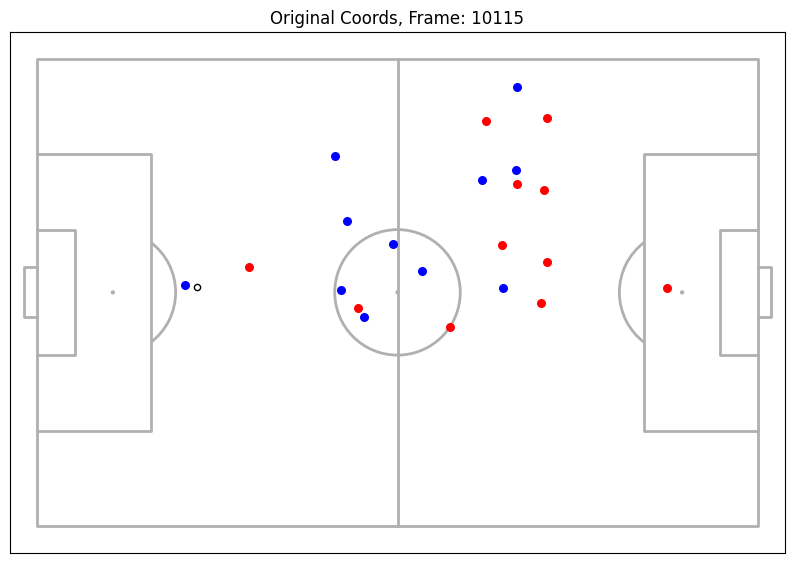

In [87]:
#10154.0
visualizers_made.get_animation_from_raw(18453000000007, 1, event, tracking,custom_frames = None, show = True, add_frames = None, frameskip = 1)

In [43]:
event[event['EVALUATION'] == 'unsuccessful'].head(10)

EVENT_ID            MUID  MATCH_DAY           PUID1  \
1    18453000000007  DFL-MAT-J03YDU          1  DFL-OBJ-0000LT   
9    18453000000016  DFL-MAT-J03YDU          1  DFL-OBJ-0027UE   
10   18453000000017  DFL-MAT-J03YDU          1  DFL-OBJ-002FWZ   
31   18453000000039  DFL-MAT-J03YDU          1  DFL-OBJ-002FW5   
53   18453000000061  DFL-MAT-J03YDU          1  DFL-OBJ-J00ZZ3   
62   18453000000071  DFL-MAT-J03YDU          1  DFL-OBJ-J01C07   
69   18453000000080  DFL-MAT-J03YDU          1  DFL-OBJ-0027BH   
80   18453000000092  DFL-MAT-J03YDU          1  DFL-OBJ-0001CE   
82   18453000000096  DFL-MAT-J03YDU          1  DFL-OBJ-002GCR   
112  18453000000127  DFL-MAT-J03YDU          1  DFL-OBJ-J01APO   

             Player1  SHIRT_NUMBER1           CUID1              Club1  \
1         S. Ulreich             26  DFL-CLU-00000G  FC Bayern München   
9        J. Pavlenka              1  DFL-CLU-00000E   SV Werder Bremen   
10   Alphonso Davies             19  DFL-CLU-00000G  FC Bayern München   
31         A. Pieper              5  DFL-CLU-00000E   SV Werder Bremen   
53        Harry Kane              9  DFL-CLU-00000G  FC Bayern München   
62        Jens Stage              6  DFL-CLU-00000E   SV Werder Bremen   
69         M. Friedl             32  DFL-CLU-00000E   SV Werder Bremen   
80        M. Ducksch              7  DFL-CLU-00000E   SV Werder Bremen   
82        J. Musiala             42  DFL-CLU-00000G  FC Bayern München   
112      N. Mazraoui             40  DFL-CLU-00000G  FC Bayern München   

    Club1_Three_Letter_Code           PUID2  ... PossSpeed  PossAng  \
1                       FC   DFL-OBJ-0000YO  ...      0,16     7,14   
9                       SV   DFL-OBJ-002FWZ  ...      0,16     7,14   
10                      FC   DFL-OBJ-J01C07  ...      0,62     7,14   
31                      SV   DFL-OBJ-J01AE6  ...         0        0   
53                      FC   DFL-OBJ-002FW5  ...         0        0   
62                      SV   DFL-OBJ-J01AE6  ...      0,31        0   
69                      SV   DFL-OBJ-002FWZ  ...      0,16     7,14   
80                      SV   DFL-OBJ-J00ZZ3  ...         0        0   
82                      FC   DFL-OBJ-0026UB  ...      0,31        0   
112                     FC              NaN  ...         0        0   

    Dis_nearest_opp_rec Dist_of_pass Nearest_Defender_to_passing_lane  \
1                  5,16        45,83                             0,68   
9                  10,7        47,67                             1,14   
10                 3,79        12,83                             0,91   
31                    0            0                                0   
53                 0,56         9,35                             0,11   
62                 4,38        11,27                             1,05   
69                 7,62        46,06                             5,68   
80                 1,72        31,78                             0,44   
82                  6,3        21,41                             0,63   
112                3,93         7,62                             0,89   

     Angle_of_pass OneTouch Time_of_Possesion BlockProb Opp_Players_in_path  
1            19,45      0.0              8,24         0                 2.0  
9            28,91      0.0              1,48         0                 3.0  
10           40,77      1.0              0,04         0                 1.0  
31           75,31      0.0              1,24         0                 0.0  
53           90,92      1.0              0,16         0                 2.0  
62           94,99      0.0               1,4         0                 3.0  
69           46,26      0.0              1,76         0                 4.0  
80           59,02      0.0              0,04         0                 6.0  
82           94,53      0.0              3,04         0                 6.0  
112          78,12      0.0              1,68         0                 1.0  

[10 rows x 61 columns]

In [ ]:
def getAngleChange(tracking, pass_start_map):
    """
    Compute angle change between ball direction at pass start and at each frame.

    Parameters:
    - tracking: DataFrame with ball tracking data (must contain 'N', 'X', 'Y', 'GameSection', 'TeamId')
    - pass_start_map: dict or Series mapping frame N to pass start frame N0

    Returns:
    - DataFrame with X, Y, angle_change, N, and GameSection
    """
    ball_data_df = tracking[tracking['TeamId'] == 'BALL'].copy()
    ball_data_df['N'] = ball_data_df['N'].astype(float)
    ball_data_df['X'] = ball_data_df['X'].astype(float)
    ball_data_df['Y'] = ball_data_df['Y'].astype(float)
    ball_data_df = ball_data_df.sort_values(by='N')

    # Compute dx, dy for current frame
    ball_data_df['dx'] = ball_data_df.groupby('GameSection')['X'].shift(-5) - ball_data_df['X']
ball_data_df['dy_fwd5'] = ball_data_df.groupby('GameSection')['Y'].shift(-5) - ball_data_df['Y']
    ball_data_df['magnitude'] = np.sqrt(ball_data_df['dx']**2 + ball_data_df['dy']**2)

    # Map each N to its pass start frame
    ball_data_df['pass_start_N'] = ball_data_df['N'].map(pass_start_map)

    # Get dx/dy at pass start by merging back on N
    pass_starts = ball_data_df[['N', 'dx', 'dy', 'magnitude']].rename(
        columns={'N': 'pass_start_N', 'dx': 'start_dx', 'dy': 'start_dy', 'magnitude': 'start_magnitude'}
    )
    ball_data_df = ball_data_df.merge(pass_starts, on='pass_start_N', how='left')

    # Compute dot product between current and pass start vectors
    ball_data_df['dot_product'] = (ball_data_df['dx'] * ball_data_df['start_dx'] +
                                   ball_data_df['dy'] * ball_data_df['start_dy'])

    # Calculate angle in degrees
    cosine_values = ball_data_df['dot_product'] / (ball_data_df['magnitude'] * ball_data_df['start_magnitude'])
    cosine_values = np.clip(cosine_values, -1, 1)
    ball_data_df['angle_change'] = np.degrees(np.arccos(cosine_values))

    # Clean up infinities and NaNs
    ball_data_df['angle_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
    ball_data_df['angle_change'].fillna(0, inplace=True)

    return ball_data_df[['X', 'Y', 'angle_change', 'N','pass_start_N', 'GameSection', 'start_dx', 'start_dy', 'start_magnitude']]

N  angle_change  pass_start_angle
0        10000.0           0.0          0.000000
1        10001.0           0.0          0.000000
2        10002.0           0.0          0.000000
3        10003.0           0.0          0.165924
4        10004.0           0.0          0.186962
...          ...           ...               ...
148271  176307.0           0.0          0.000000
148272  176308.0           0.0          0.000000
148273  176309.0           0.0          0.000000
148274  176310.0           0.0          0.000000
148275  176311.0           0.0          0.000000

[148276 rows x 3 columns]

In [99]:
test_cases = [18453000000598,
18453000000690,
18453000000691,
18453000000727,
18453000000737,
18453000000761,
18453000000783,
18453000000851,
18453000000867,
18453000000873,
18453000000875,
18453000000890,
18453000000910,
18453000000933,
18453000000946,
18453000001006,
18453000001024,
18453000001026,
18453000001068,
18453000001104,
18453000001114,
18453000001189,
18453000001191,
18453000001263,
18453000001276,
18453000001337,
18453000001349,
18453000001362,
18453000001368,
18453000001414,
18453000001436]

In [133]:
direct = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_nodefl"
buli_ff = pd.read_parquet(f"{direct}/x_freeze_frame_360.parquet")
buli_end = pd.read_parquet(f"{direct}/x_endlocation.parquet")
buli_start = pd.read_parquet(f"{direct}/x_startlocation.parquet")
buli_speed = pd.read_parquet(f"{direct}/x_speed.parquet")

In [134]:
direct = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_defl"
buli_ff_d = pd.read_parquet(f"{direct}/x_freeze_frame_360.parquet")
buli_end_d = pd.read_parquet(f"{direct}/x_endlocation.parquet")
buli_start_d = pd.read_parquet(f"{direct}/x_startlocation.parquet")
buli_speed_d = pd.read_parquet(f"{direct}/x_speed.parquet")

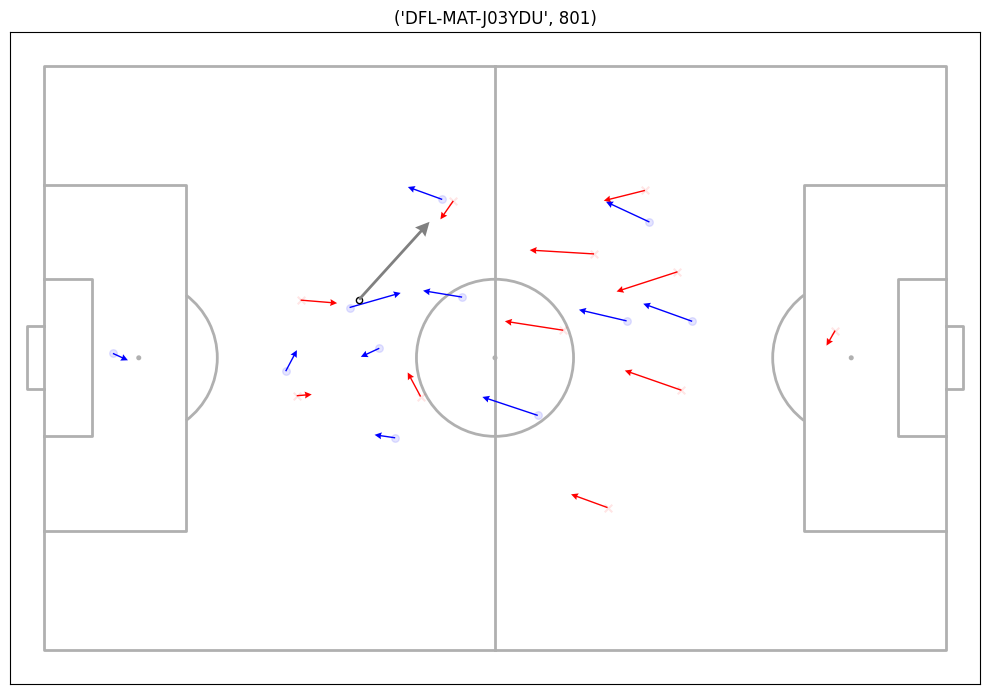

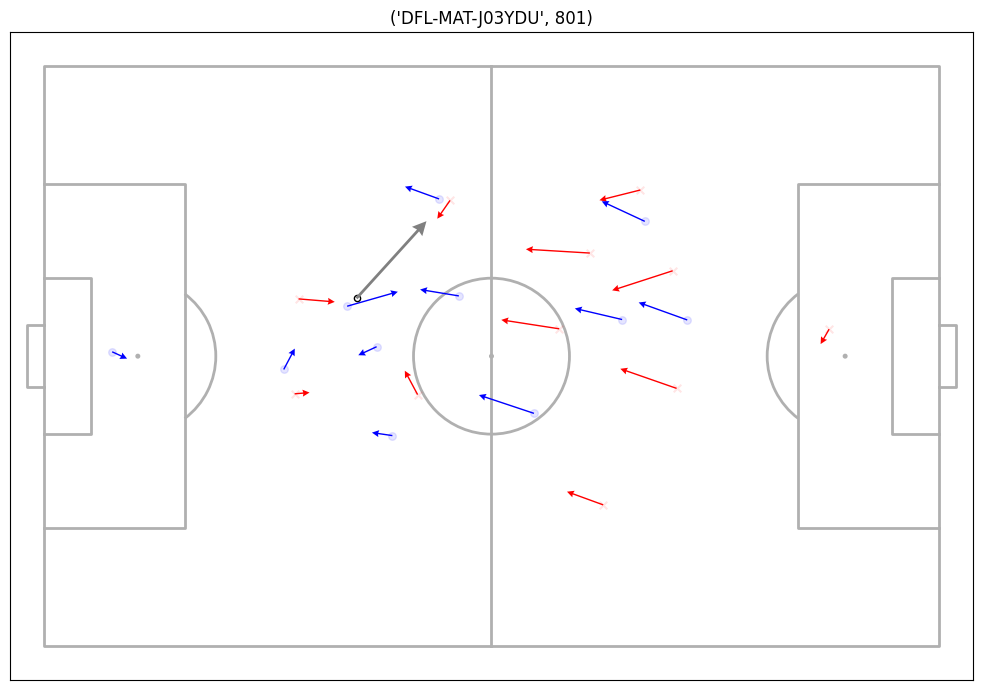

In [145]:
from unxpass.converters import playVisualizers
import mplsoccer
game_actions = db.actions(game_id = "DFL-MAT-J03YDU")
buliEvent = test_cases[6]
sqlId = game_actions[game_actions['original_event_id'].astype(float) == buliEvent]
idx = sqlId.index[0]
playVisualizers.visualize_coords_from_parquet(buli_ff, buli_start, buli_speed, idx, end = buli_end, title = f"{str(idx)}")

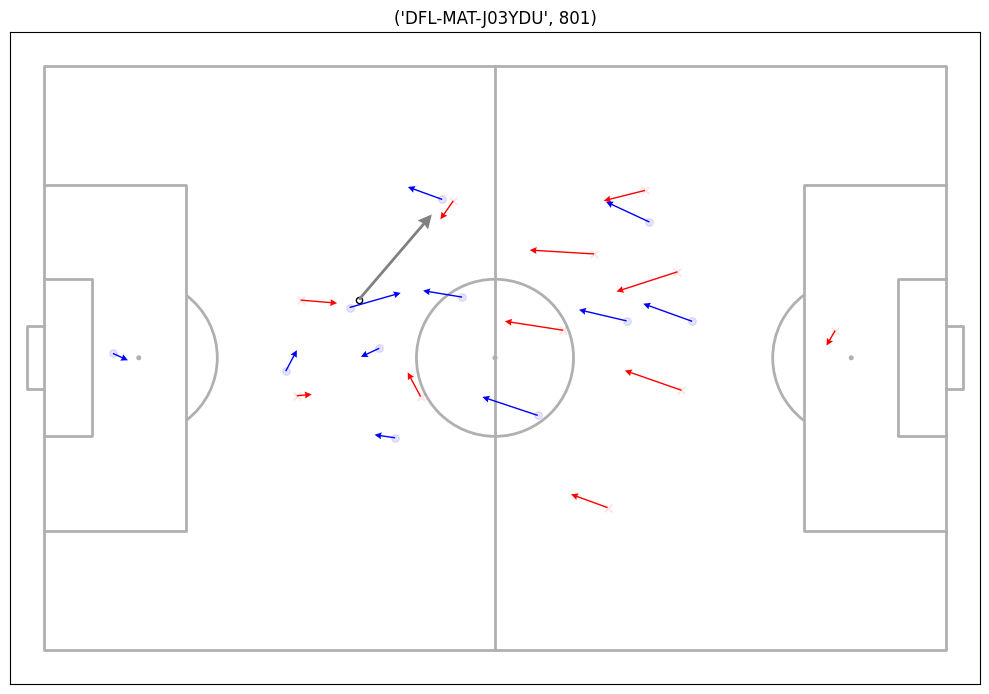

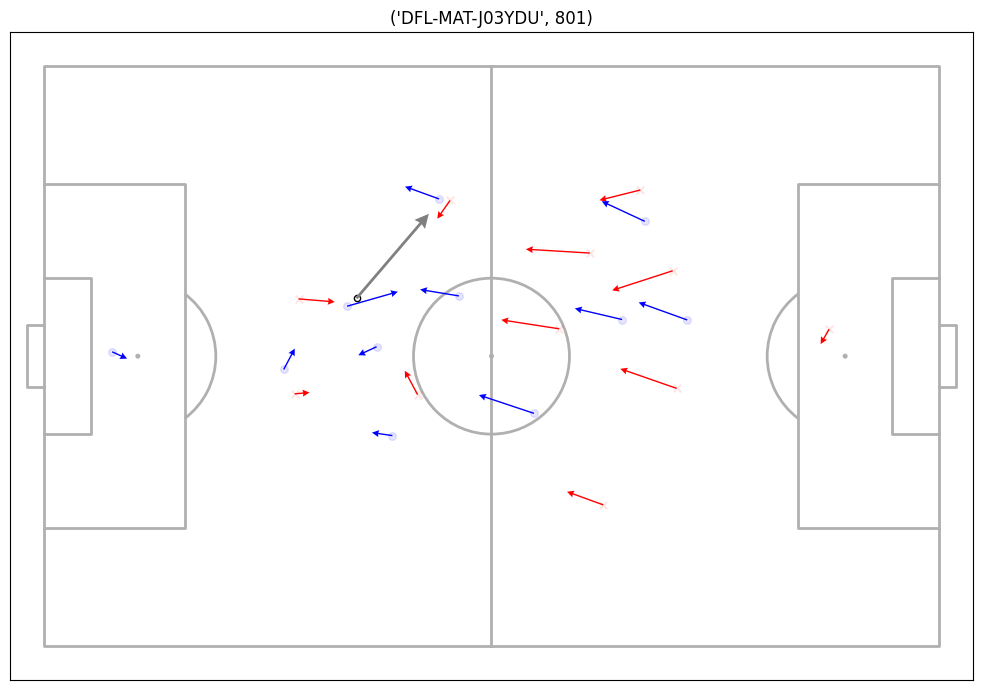

In [146]:
playVisualizers.visualize_coords_from_parquet(buli_ff_d, buli_start_d, buli_speed_d, idx, end = buli_end_d, title = f"{str(idx)}")

In [ ]:
from unxpass.converters import playVisualizers
import mplsoccer
pdf_filename = "Recipient_GKTest.pdf"
with PdfPages(pdf_filename) as pdf:
    for idx in buli_ff.index[0:500]:
        success = buli_success['success'].loc[idx]
        fig = playVisualizers.visualize_coords_from_parquet(buli_ff, buli_start, buli_speed, idx, end = buli_end, title = f"{str(idx)} | {success}")
        pdf.savefig(fig)
        plt.close(fig)


In [ ]:
import numpy as np

def point_to_segment_distance(P, A, B):
    """
    Compute the shortest distance from point P to line segment AB.
    
    P: np.array - the point
    A: np.array - segment start point
    B: np.array - segment end point

    Returns: float - distance from P to closest point on segment
             np.array - the closest point on the segment
    """
    P, A, B = np.array(P), np.array(A), np.array(B)
    AB = B - A
    AP = P - A
    AB_squared = np.dot(AB, AB)
    if AB_squared == 0:
        # A and B are the same point
        return np.linalg.norm(P - A), A
    # Compute the projection scalar of AP onto AB
    t = np.dot(AP, AB) / AB_squared
    t_clamped = np.clip(t, 0, 1)
    # Closest point on the segment
    closest_point = A + t_clamped * AB
    distance = np.linalg.norm(P - closest_point)
    return distance, closest_point

def getClosestPlayer_vec(row, freeze_frame, start):
    idx = row.name
    ff = freeze_frame.loc[idx, "freeze_frame_360_a0"]
    start = start.loc[idx]
    start_tuple = start[["start_x_a0", "start_y_a0"]].values
    end_tuple = row[["end_x_a0", "end_y_a0"]].values
    locs = {player['player'] : [player['x'], player['y']] for player in ff if player['teammate'] == True and player['actor'] == False}
    distances = {player: point_to_segment_distance(locs[player], start_tuple, end_tuple)[0] for player in locs}
    closest_player = min(distances, key=distances.get)
    return pd.Series(locs[closest_player], index=["test_x", "test_y"])

In [ ]:
buli_end[['test_x', 'test_y']] = buli_end.apply(lambda row: getClosestPlayer_vec(row, buli_ff, buli_start), axis=1)

In [ ]:
idx = ('DFL-MAT-J03YDU', 2)
visualize_coords_from_parquet(buli_ff, buli_start, buli_speed, closest_vec= getClosestPlayer_vec(buli_end.loc[idx], buli_ff, buli_start), closest_line= getClosestPlayer_line(buli_end.loc[idx], buli_ff, buli_start), action_tuple = idx, end = buli_end, title = f"{str(idx)} | {successful}")

In [ ]:
from unxpass.converters import playVisualizers
import mplsoccer
pdf_filename = "ClosestPlayerLineVec.pdf"
with PdfPages(pdf_filename) as pdf:
    for idx in buli_success[~buli_success['success']].index[0:500]:
        successful = buli_success.loc[idx, "success"]
        fig = visualize_coords_from_parquet(buli_ff, buli_start, buli_speed, closest_vec= getClosestPlayer_vec(buli_end.loc[idx], buli_ff, buli_start), closest_line= getClosestPlayer_line(buli_end.loc[idx], buli_ff, buli_start), action_tuple = idx, end = buli_end, title = f"{str(idx)} | {successful}")
        pdf.savefig(fig)
        plt.close(fig)



In [ ]:
def getDistanceThreshold(start_df, end_df, success, threshold):
    distances = np.sqrt(
        (end_df['end_x_a0'].values - start_df['start_x_a0'].values) ** 2 +
        (end_df['end_y_a0'].values - start_df['start_y_a0'].values) ** 2
    )
    condition = success['success'].values | (distances > threshold)
    return start_df.index[condition]

('DFL-MAT-J03YDX', 0) in getDistanceThreshold(buli_start, buli_end, buli_success, 20)

In [47]:
game_id, action_id = 'DFL-MAT-J03YDU', 330
event_id = db.actions(game_id = game_id).loc[(game_id, action_id)]['original_event_id']
from unxpass import visualizers_made
#events, tracking = visualizers_made.animationHelper(game_id)

In [48]:
event_id

'18453000000330.0'

In [ ]:
start_frame = events[events["EVENT_ID"] == float(event_id)].iloc[0]["FRAME_NUMBER"]
visualizers_made.get_animation_from_raw(float(event_id), 1, events, tracking,custom_frames = range(start_frame, start_frame + 75), show = True, add_frames = None, frameskip = 1)

In [ ]:
def getReceipts(tracking, eventdf):
    eventdf = eventdf.sort_values(by = "FRAME_NUMBER").sort_values(by='RECFRM', na_position='last')
    eventdf['RECFRM'] = eventdf.groupby('FRAME_NUMBER')['RECFRM'].transform(
    lambda x: x.fillna(x.dropna().iloc[0]) if not x.dropna().empty else x
        )
    eventdf["NEXT_FRAME"] = eventdf["FRAME_NUMBER"].shift(-1).fillna(method='bfill')
    eventdf.loc[eventdf["NEXT_FRAME"] == eventdf["FRAME_NUMBER"], "NEXT_FRAME"] = np.nan
    eventdf["NEXT_FRAME"] = eventdf["NEXT_FRAME"].fillna(method='bfill')
    eventdf.loc[abs(eventdf["NEXT_FRAME"] - eventdf["FRAME_NUMBER"]) > 300, "NEXT_FRAME"] = eventdf.loc[abs(eventdf["NEXT_FRAME"] - eventdf["FRAME_NUMBER"]) > 300, "FRAME_NUMBER"]
    tracking["N"] = tracking["N"].astype(float)
    tracking["X"] = tracking["X"].astype(float)
    tracking["Y"] = tracking["Y"].astype(float)
    eventdf["RECFRM"] = eventdf.apply(lambda row: add_speed.getClosestFrame(row, tracking), axis = 1)
    mask = eventdf['RECFRM'] == eventdf['FRAME_NUMBER']
    eventdf.loc[mask, "RECFRM"] = eventdf.loc[mask].apply(lambda row: getOutOfBounds(row, tracking), axis = 1)
    return eventdf
def getOutOfBounds(row, tracking):
    outOfBounds = (abs(tracking['X']) > 52.2) | (abs(tracking['Y']) > 34)
    start_frame = row["FRAME_NUMBER"]
    end_frame = row['RECFRM'] + 300
    ball_data = tracking[(tracking["N"] >= start_frame) & (tracking["N"] <= end_frame) & (tracking["TeamId"] == "BALL")]
    ball_data = ball_data[(outOfBounds)]
    if len(ball_data) > 0:
        return min(ball_data["N"])
    else:
        return row['RECFRM']

In [ ]:
from unxpass.Scripts import add_speed
receipts = getReceipts(tracking, events)

In [ ]:
receipts[receipts["EVENT_ID"] == float(event_id)]

In [ ]:
receipts[receipts["EVENT_ID"] == float(event_id)]
receipts.loc[308:350]

In [ ]:
buli_ff = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_outliers_fail/x_freeze_frame_360.parquet")
buli_end = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_outliers_fail/x_endlocation.parquet")
buli_start = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_outliers_fail/x_startlocation.parquet")
buli_speed = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_outliers_fail/x_speed.parquet")

In [ ]:
from unxpass.converters import playVisualizers
idx = buli_start.index[0]
playVisualizers.visualize_coords_from_parquet(buli_ff, buli_start, buli_speed, action_tuple = idx,  end = buli_end, title = str(idx))

In [ ]:
from tqdm import tqdm
pdf_filename = "allFailed.pdf"
with PdfPages(pdf_filename) as pdf:
    for action_tuple in tqdm(buli_start.index[0:500]):
        fig = playVisualizers.visualize_coords_from_parquet(buli_ff, buli_start, buli_speed, action_tuple = action_tuple,  end = buli_end, title = str(action_tuple))
        #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)

In [ ]:
sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequence_filtered.csv", delimiter = ";")
tracking = pd.read_csv("/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/tracking_csvs/2032207_Norway_Northern Ireland.csv")

In [ ]:
ballreceipt = 1036.053187 + 45*60
sequences[(sequences['match_id'] == 3835320)& (sequences['index'] == 2168)][["GameID", "BallReceipt"]]
sequences

In [ ]:
ballreceipt % 60, ballreceipt / 60

In [ ]:
prior = ballreceipt - 5 * .04
post = ballreceipt + 5 * .04
tracking[(tracking['elapsed'] >= prior) & (tracking['elapsed'] <= post) & (tracking['uefaId'] == 67772)].sort_values(by = "time")
pos1 = [27.307866286244433, 22.319666629039727]
pos2 = [27.340959541748692, 21.84866506489929]
x_velo = (pos2[0] - pos1[0]) / (10 * .04)
y_velo = (pos2[1] - pos1[1]) / (10 * .04)
x_velo, y_velo

In [ ]:
[player for player in ff['freeze_frame_360_a0'] if (player['goalkeeper'] == True) and (player['teammate'] == True)]
#ff['freeze_frame_360_a0']

In [ ]:
from unxpass.components.withSpeeds import pass_selection_speeds
custom_path = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_Features/Hawkeye_Features_Updated_wSecond_test"
dataset_test = partial(PassesDataset, path=custom_path)
model = pass_selection_speeds.SoccerMapComponent(
    model=mlflow.pytorch.load_model(
        'runs:/739d103329bf4d399fbb8d311859382a/model', map_location='cpu'
        #'runs:/788ec5a232af46e59ac984d50ecfc1d5/model', map_location='cpu'
    )
)
sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequence_filtered.csv", delimiter = ";")
surfaces = model.predict_surface(dataset_test, model_name = "sel")

In [ ]:
from pathlib import Path
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlflow
from scipy.ndimage import zoom
import warnings
from unxpass.databases import SQLiteDatabase
from unxpass.datasets import PassesDataset, CompletedPassesDataset, FailedPassesDataset
from unxpass.components import pass_selection, pass_value, pass_success, pass_value_custom
from unxpass.components.withSpeeds import pass_value_speeds
from unxpass.components.utils import load_model
from unxpass.visualization import plot_action
from unxpass.converters import playVisualizers
from unxpass.ratings_custom import LocationPredictions
from matplotlib.backends.backend_pdf import PdfPages

def visualize_coords_from_tracking(freeze_frame, start, speed, action_tuple, title = None, surfaces = None, surface_kwargs = None, ax = None, log = False):
    ff_action = freeze_frame.loc[action_tuple, 'freeze_frame_360_a0']
    teammate_x = [player['x'] for player in ff_action if player['teammate']]
    teammate_y = [player['y'] for player in ff_action if player['teammate']]
    opponent_x = [player['x'] for player in ff_action if not player['teammate']]
    opponent_y = [player['y'] for player in ff_action if not player['teammate']]
    x_velo = [player['x_velo'] for player in ff_action]
    y_velo = [player['y_velo'] for player in ff_action]
    ball_x = start.loc[action_tuple, 'start_x_a0']
    ball_y = start.loc[action_tuple, 'start_y_a0']
    pitch = mplsoccer.pitch.Pitch(pitch_type='custom', 
                  half=False,         # Show only half the pitch (positive quadrant)
                  pitch_length=105,   # Length of the pitch (in meters)
                  pitch_width=68,     # Width of the pitch (in meters)
                  goal_type='box',
                  axis=True)          # Show axis for coordinates
    
    # Create a figure
    if ax is None:
        fig, ax = pitch.draw(figsize=(10, 7))
    else:
        pitch.draw(ax=ax)
    for player in ff_action:
        start_x, start_y = player['x'], player['y']
        end_x, end_y = player['x'] + player['x_velo'], player['y'] + player['y_velo']
        pitch.arrows(start_x, start_y, end_x, end_y, width=1, headwidth=5, color='gray', ax=ax)
    # Scatter the start and end points for clarity
    pitch.scatter(opponent_x, opponent_y, c="r", s=30, ax=ax, marker = "x")
    pitch.scatter(teammate_x, teammate_y, c="b", s=30, ax=ax, marker = "o")
    pitch.scatter([ball_x], [ball_y], c="w", ec = "k", s=20, ax=ax)
    if surfaces is not None:
        surface = surfaces[action_tuple[0]][action_tuple[1]]
        if log:
            ax.imshow(np.log(surface), extent=[0.0, 105.0, 0.0, 68.0], origin="lower", **surface_kwargs)
        else:
            ax.imshow(surface, extent=[0.0, 105.0, 0.0, 68.0], origin="lower", **surface_kwargs)
    
    # Set labels
    ax.set_title(title)
    
    # Show the plot
    plt.show()
import unxpass.converters.playVisualizers
from unxpass.components.withSpeeds import pass_selection_speeds

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def animate_tracking_sequence(freeze_frame_df, start_df, speed_df, action_tuples, 
                               surfaces=None, surface_kwargs=None, log=False, interval=1000, title_prefix="Action"):
    """
    Creates an animation of player coordinates and surfaces for a sequence of actions.
    
    Parameters:
        freeze_frame_df: DataFrame containing freeze frame data
        start_df: DataFrame with starting ball positions
        speed_df: (unused but kept for compatibility)
        action_tuples: List of (index0, index1) tuples identifying each frame to plot
        surfaces: Optional 2D list of surface arrays
        surface_kwargs: Arguments to pass to imshow (e.g., cmap, vmin/vmax)
        log: Whether to apply np.log to surface
        interval: Time in ms between frames
        title_prefix: Prefix for subplot title
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    pitch = mplsoccer.pitch.Pitch(pitch_type='custom',
                                  half=False,
                                  pitch_length=105,
                                  pitch_width=68,
                                  goal_type='box',
                                  axis=True)
    pitch.draw(ax=ax)

    def update(frame):
        ax.clear()
        action_tuple = action_tuples[frame]
        visualize_coords_from_tracking(
            freeze_frame_df,
            start_df,
            speed_df,
            action_tuple,
            title=f"{title_prefix} {frame+1}",
            surfaces=surfaces,
            surface_kwargs=surface_kwargs,
            ax=ax,
            log=log
        )

    anim = FuncAnimation(fig, update, frames=len(action_tuples), interval=interval, repeat=False)
    plt.close(fig)
    return anim



    
def getAnimation(index, game_id, sequence, surfaces, freeze_frame, start, speed, log = False):
    play_surfaces = {k:v for k,v in surfaces[game_id].items() if k.split("-")[0] == str(index)}
    action_tuples = [(game_id, key) for key in play_surfaces.keys()]
    animation = animate_tracking_sequence(freeze_frame, start, speed, action_tuples, surfaces = surfaces, surface_kwargs = {"interpolation":"bilinear", "vmin": None, "vmax": None, "cmap": "Greens"}, log = log)
    return animation
def main(num_to_generate = 5):
    custom_path = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_Features/Hawkeye_Features_Updated_wSecond_test"
    dataset_test = partial(PassesDataset, path=custom_path)
    model = pass_selection_speeds.SoccerMapComponent(
        model=mlflow.pytorch.load_model(
            'runs:/739d103329bf4d399fbb8d311859382a/model', map_location='cpu'
            #'runs:/788ec5a232af46e59ac984d50ecfc1d5/model', map_location='cpu'
        )
    )
    sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequence_filtered.csv", delimiter = ";")
    surfaces = model.predict_surface(dataset_test, model_name = "sel")
    freeze_frame_df = pd.read_parquet(f"{custom_path}/x_freeze_frame_360.parquet")
    speed_df = pd.read_parquet(f"{custom_path}/x_speed.parquet")
    start_df = pd.read_parquet(f"{custom_path}/x_startlocation.parquet")
    for anim in range(num_to_generate):
        idx = sequences.iloc[anim, "index"]
        print(idx)
        game_id = sequences.iloc[anim, "match_id"]
        animation = getAnimation(sequences, game_id, idx, freeze_frame_df, start_df, speed_df, surfaces)
        animation_title = f"animations/{game_id}_{idx}.mp4"
        animation.save(animation_title, writer='ffmpeg', fps=1, dpi=200)
main()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def animate_tracking(freeze_frame, start, speed, action_tuples, surfaces=None, surface_kwargs=None, log=False):
    fig, ax = plt.subplots(figsize=(10, 7))

    def update(i):
        ax.clear()
        action_tuple = action_tuples[i]
        visualize_coords_from_tracking(
            freeze_frame=freeze_frame,
            start=start,
            speed=speed,
            action_tuple=action_tuple,
            title=f"Frame {i}: Action {action_tuple}",
            surfaces=surfaces,
            surface_kwargs=surface_kwargs,
            ax=ax,
            log=log
        )
    ani = FuncAnimation(fig, update, frames=len(action_tuples), repeat=False)
    plt.close(fig)  # Prevents static image in notebooks
    return ani


In [ ]:
import mplsoccer
freeze_frame_df = pd.read_parquet(f"{custom_path}/x_freeze_frame_360.parquet")
speed_df = pd.read_parquet(f"{custom_path}/x_speed.parquet")
start_df = pd.read_parquet(f"{custom_path}/x_startlocation.parquet")
idx = 2168
game_id = 3835320
play_surfaces = {k:v for k,v in surfaces[game_id].items() if k.split("-")[0] == str(idx)}
play_surfaces.keys()
action_tuple = (game_id, '2168-0')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def animate_tracking_sequence(freeze_frame_df, start_df, speed_df, action_tuples, 
                               surfaces=None, surface_kwargs=None, log=False, interval=1000, title_prefix="Action"):
    """
    Creates an animation of player coordinates and surfaces for a sequence of actions.
    
    Parameters:
        freeze_frame_df: DataFrame containing freeze frame data
        start_df: DataFrame with starting ball positions
        speed_df: (unused but kept for compatibility)
        action_tuples: List of (index0, index1) tuples identifying each frame to plot
        surfaces: Optional 2D list of surface arrays
        surface_kwargs: Arguments to pass to imshow (e.g., cmap, vmin/vmax)
        log: Whether to apply np.log to surface
        interval: Time in ms between frames
        title_prefix: Prefix for subplot title
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    pitch = mplsoccer.pitch.Pitch(pitch_type='custom',
                                  half=False,
                                  pitch_length=105,
                                  pitch_width=68,
                                  goal_type='box',
                                  axis=True)
    pitch.draw(ax=ax)

    def update(frame):
        ax.clear()
        action_tuple = action_tuples[frame]
        print(action_tuple)
        visualize_coords_from_tracking(
            freeze_frame_df,
            start_df,
            speed_df,
            action_tuple,
            title=f"{title_prefix} {frame+1}",
            surfaces=surfaces,
            surface_kwargs=surface_kwargs,
            ax=ax,
            log=log
        )

    anim = FuncAnimation(fig, update, frames=len(action_tuples), interval=interval, repeat=False)
    plt.close(fig)
    return anim
action_tuples = [(game_id, key) for key in play_surfaces.keys()]

In [ ]:
def visualize_coords_from_tracking(freeze_frame, start, speed, action_tuple, title = None, surfaces = None, surface_kwargs = None, ax = None, log = False):
    print(action_tuple)
    ff_action = freeze_frame.loc[action_tuple, 'freeze_frame_360_a0']
    #print(ff_action)
    teammate_x = [player['x'] for player in ff_action if player['teammate']]
    teammate_y = [player['y'] for player in ff_action if player['teammate']]
    opponent_x = [player['x'] for player in ff_action if not player['teammate']]
    opponent_y = [player['y'] for player in ff_action if not player['teammate']]
    x_velo = [player['x_velo'] for player in ff_action]
    y_velo = [player['y_velo'] for player in ff_action]
    ball_x = start.loc[action_tuple, 'start_x_a0']
    ball_y = start.loc[action_tuple, 'start_y_a0']
    pitch = mplsoccer.pitch.Pitch(pitch_type='custom', 
                  half=False,         # Show only half the pitch (positive quadrant)
                  pitch_length=105,   # Length of the pitch (in meters)
                  pitch_width=68,     # Width of the pitch (in meters)
                  goal_type='box',
                  axis=True)          # Show axis for coordinates
    
    # Create a figure
    if ax is None:
        fig, ax = pitch.draw(figsize=(10, 7))
    else:
        pitch.draw(ax=ax)
    for player in ff_action:
        start_x, start_y = player['x'], player['y']
        end_x, end_y = player['x'] + player['x_velo'], player['y'] + player['y_velo']
        pitch.arrows(start_x, start_y, end_x, end_y, width=1, headwidth=5, color='gray', ax=ax)
    # Scatter the start and end points for clarity
    pitch.scatter(opponent_x, opponent_y, c="r", s=30, ax=ax, marker = "x")
    pitch.scatter(teammate_x, teammate_y, c="b", s=30, ax=ax, marker = "o")
    pitch.scatter([ball_x], [ball_y], c="w", ec = "k", s=20, ax=ax)
    if surfaces is not None:
        surface = surfaces[action_tuple[0]][action_tuple[1]]
        if log:
            ax.imshow(np.log(surface), extent=[0.0, 105.0, 0.0, 68.0], origin="lower", **surface_kwargs)
        else:
            ax.imshow(surface, extent=[0.0, 105.0, 0.0, 68.0], origin="lower", **surface_kwargs)
    
    # Set labels
    ax.set_title(title)
    
    # Show the plot
    plt.show()

In [ ]:
animation = animate_tracking_sequence(freeze_frame_df, start_df, speed_df, action_tuples, surfaces = surfaces, surface_kwargs = {"interpolation":"bilinear", "vmin": None, "vmax": None, "cmap": "Greens"}, log = True)

In [ ]:
from IPython.display import HTML
HTML(animation.to_jshtml())

In [ ]:
from unxpass.components.withSpeeds import pass_value_speeds

# Load raw model from ckpt
model = pass_value_speeds.PytorchSoccerMapModel.load_from_checkpoint("/home/lz80/un-xPass/unxpass/trainingscripts/lightning_logs/version_42/checkpoints/epoch=29-step=4788300.ckpt")

# Wrap it into the component (e.g., for offensive scoring)
test = pass_value_speeds.SoccerMapComponent(model=model, offensive=True)

In [ ]:
test
mlflow.set_experiment("pass_value/soccermap")
with mlflow.start_run() as run:
    # Log the model
    mlflow.pytorch.log_model(test.model, "model")

    # Retrieve the run ID
    run_id = run.info.run_id
    fail_off = run_id
    print(f"Success Offensive Model saved with run_id: {run_id}")

In [ ]:
def getGksTM(game_id, teams = False):
        lineups = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/womens_euro_receipts/lineups/{game_id}.json"
        lineup_df = pd.read_json(lineups, convert_dates = False)
        team_1 = lineup_df['team_id'].loc[0]
        team_2 = lineup_df['team_id'].loc[1]
        team_1_dict = lineup_df['lineup'].loc[0]
        team_2_dict = lineup_df['lineup'].loc[1]
        #print(lineup_df)
        team_1_lineup = [player_dict['player_id'] for player_dict in team_1_dict]
        team_2_lineup = [player_dict['player_id'] for player_dict in team_2_dict]
        team_map = {team_1 : team_1_lineup, team_2 : team_2_lineup}#building a map of team id to player ids
        player_to_team = {player_id: team_id for team_id, players in team_map.items() for player_id in players} #mapping players to teams
        pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_1_dict if len(player['positions']) > 0}
        team_2_pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_2_dict if len(player['positions']) > 0}
        pos_dict.update(team_2_pos_dict)
        goalkeepers = [key for (key,value) in pos_dict.items() if value == "Goalkeeper"]
        if teams:
            return player_to_team, goalkeepers, [team_1, team_2]
        return player_to_team, goalkeepers#gets set of goalkeepers too

In [ ]:
teams, gks = getGksTM(3835336)
teams

In [ ]:
sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequence_filtered.csv", delimiter = ";")

In [ ]:
lineups = pd.read_json(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/womens_euro/lineups/3835336.json")
lineups.loc[0]["lineup"]#ballreceipt on the opponent?

In [ ]:
import mplsoccer
def visualize_coords_from_tracking_2(freeze_frame, start, speed, action_tuple, title = None, surface = None, surface_kwargs = None, ax = None):
    ff_action = freeze_frame['freeze_frame_360_a0']
    teammate_x = [player['x'] for player in ff_action if player['teammate']]
    teammate_y = [player['y'] for player in ff_action if player['teammate']]
    opponent_x = [player['x'] for player in ff_action if not player['teammate']]
    opponent_y = [player['y'] for player in ff_action if not player['teammate']]
    actor_x = [player['x'] for player in ff_action if player['actor']]
    actor_y = [player['y'] for player in ff_action if player['actor']]
    x_velo = [player['x_velo'] for player in ff_action]
    y_velo = [player['y_velo'] for player in ff_action]
    start_x = start['start_x_a0']
    start_y = start['start_y_a0']
    pitch = mplsoccer.pitch.Pitch(pitch_type='custom', 
                  half=False,         # Show only half the pitch (positive quadrant)
                  pitch_length=105,   # Length of the pitch (in meters)
                  pitch_width=68,     # Width of the pitch (in meters)
                  goal_type='box',
                  axis=True)          # Show axis for coordinates
    
    # Create a figure
    if ax is None:
        fig, ax = pitch.draw(figsize=(10, 7))
    else:
        pitch.draw(ax=ax)
    for player in ff_action:
        start_x, start_y = player['x'], player['y']
        end_x, end_y = player['x'] + player['x_velo'], player['y'] + player['y_velo']
        pitch.arrows(start_x, start_y, end_x, end_y, width=1, headwidth=5, color='gray', ax=ax)
        if player['actor']:
            pitch.arrows(start_x, start_y, end_x, end_y, width=2, headwidth=5, color='blue', ax=ax)
    # Scatter the start and end points for clarity
    pitch.scatter(opponent_x, opponent_y, c="r", s=30, ax=ax, marker = "x")
    pitch.scatter(teammate_x, teammate_y, c="b", s=30, ax=ax, marker = "o")
    pitch.scatter([start_x], [start_y], c="w", ec = "k", s=20, ax=ax)
    pitch.scatter([actor_x], [actor_y], c="g", ec = "k", s=20, ax=ax)
    print(actor_x, start_x)
    if surface is not None:
        ax.imshow(surface, extent=[0.0, 105.0, 0.0, 68.0], origin="lower", **surface_kwargs)
    
    # Set labels
    ax.set_title(title)
    
    # Show the plot
    plt.show()

In [ ]:
player_df = pd.read_csv("/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/tracking_csvs/2032206_England_Austria.csv")
ball_df = pd.read_csv("/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/tracking_ball_csvs/2032206_England_Austria.csv")

In [ ]:
import mplsoccer
import ast
def visualize_raw(player_df, ball_df, time, surface = None, ax = None, title = None):
    player_time = player[player['elapsed'] == time]
    ball_time = ball[ball['elapsed'] == time]
    player_x = [float(ast.literal_eval(pos)[0]) + 105/2 for pos in player_time['position']]
    player_y = [float(ast.literal_eval(pos)[1]) + 68/2 for pos in player_time['position']]
    ball_pos = ast.literal_eval(ball_time.iloc[0]['position'])
    ball_x = float(ball_pos[0]) + 105/2
    ball_y = float(ball_pos[1]) + 68/2
    pitch = mplsoccer.pitch.Pitch(pitch_type='custom', 
                  half=False,         # Show only half the pitch (positive quadrant)
                  pitch_length=105,   # Length of the pitch (in meters)
                  pitch_width=68,     # Width of the pitch (in meters)
                  goal_type='box',
                  axis=True)          # Show axis for coordinates
    
    # Create a figure
    if ax is None:
        fig, ax = pitch.draw(figsize=(10, 7))
    else:
        pitch.draw(ax=ax)
    # Scatter the start and end points for clarity
    pitch.scatter(player_x, player_y, c="gray", s=30, ax=ax, marker = "o")
    pitch.scatter([ball_x], [ball_y], c="black", s=40, ax=ax, marker = "o")
    if surface is not None:
        ax.imshow(surface, extent=[0.0, 105.0, 0.0, 68.0], origin="lower", **surface_kwargs)
    
    # Set labels
    ax.set_title(title)
    
    # Show the plot
    plt.show()

In [ ]:
import mplsoccer
import ast
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

def visualize_frame(player_df, ball_df, time, ax, title=None, surface=None, surface_kwargs={}):
    """
    Draw a single frame for the given time.
    """
    # Clear the axis for a new frame
    ax.clear()
    
    # For float comparisons, consider using a tolerance (if needed)
    # Here we assume that the elapsed times in your dataframe exactly match the generated time values.
    player_time = player_df[player_df['elapsed'] == time]
    ball_time = ball_df[ball_df['elapsed'] == time]
    
    # If the above exact equality fails due to floating point issues, try:
    # tol = 1e-3
    # player_time = player_df[np.abs(player_df['elapsed'] - time) < tol]
    # ball_time = ball_df[np.abs(ball_df['elapsed'] - time) < tol]

    # Extract and adjust player positions
    player_x = [float(ast.literal_eval(pos)[0]) + 105/2 for pos in player_time['position']]
    player_y = [float(ast.literal_eval(pos)[1]) + 68/2 for pos in player_time['position']]
    
    # Extract and adjust ball position
    ball_pos = ast.literal_eval(ball_time.iloc[0]['position'])
    ball_x = float(ball_pos[0]) + 105/2
    ball_y = float(ball_pos[1]) + 68/2
    
    # Create the pitch
    pitch = mplsoccer.pitch.Pitch(
        pitch_type='custom', 
        half=False,         # Show full pitch
        pitch_length=105,   # Pitch length in meters
        pitch_width=68,     # Pitch width in meters
        goal_type='box',
        axis=True           # Show axis for coordinates
    )
    
    # Draw the pitch on the provided axis
    pitch.draw(ax=ax)
    
    # Optionally, if a surface image is provided, display it
    if surface is not None:
        ax.imshow(surface, extent=[0.0, 105.0, 0.0, 68.0], origin="lower", **surface_kwargs)
    
    # Scatter the player positions and ball position
    pitch.scatter(player_x, player_y, c="gray", s=30, ax=ax, marker="o")
    pitch.scatter([ball_x], [ball_y], c="black", s=40, ax=ax, marker="o")
    
    # Set the title with the time included
    ax.set_title(f"{title} - Time: {time:.2f}" if title else f"Time: {time:.2f}")

def animate_game(player_df, ball_df, lower_time, upper_time, title=None, surface=None, surface_kwargs={}):
    """
    Animate the game state over a time range specified by the lower and upper bounds.
    Real number times are generated using np.linspace.

    Parameters:
    - player_df: DataFrame containing player positions.
    - ball_df: DataFrame containing ball positions.
    - lower_time: The starting time (inclusive).
    - upper_time: The ending time (inclusive).
    - num_frames: Number of frames to generate between lower_time and upper_time.
    - title: Optional title for the plot.
    - surface: Optional image array for the pitch surface.
    - surface_kwargs: Additional keyword arguments for ax.imshow if using a surface.

    Returns:
    - ani: The created FuncAnimation object.
    """
    # Generate an array of time frames with real numbers
    time_frames = list(ball_df[(ball_df['elapsed'] >= lower_time - .1) & (ball_df['elapsed'] <= upper_time + .1)].sort_values(by = 'elapsed')['elapsed'])
    # Create a figure and axis to be used by the animation
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Update function for each frame of the animation
    def update(frame_index):
        current_time = time_frames[frame_index]
        visualize_frame(player_df, ball_df, current_time, ax, title=title, surface=surface, surface_kwargs=surface_kwargs)
    
    # Create the animation: interval is in milliseconds (e.g., 1000ms = 1 second per frame)
    ani = FuncAnimation(fig, update, frames=len(time_frames), interval=1000, repeat=True)
    
    plt.show()
    return ani

# Example usage:
# Suppose you have your dataframes `player_df` and `ball_df` and you want to animate from time 0.0 to 90.0 seconds.
# ani = animate_game(player_df, ball_df, lower_time=0.0, upper_time=90.0, num_frames=200, title="Game Animation")


In [ ]:
ball_df[(ball_df["elapsed"] > 840) & (ball_df['elapsed'] < 845)]

In [ ]:
game_id = "2032218_Netherlands_Sweden"
player_df = pd.read_csv(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/tracking_csvs/{game_id}.csv")
ball_df = pd.read_csv(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/tracking_ball_csvs/{game_id}.csv")

In [ ]:
from IPython.display import HTML
# Assuming `ani` is your animation object created by animate_game
lower_time, upper_time = 1449.873353, 1461.873353
ani = animate_game(player_df, ball_df, lower_time, upper_time,  title=None, surface=None, surface_kwargs={})
HTML(ani.to_jshtml())

In [ ]:
from unxpass.converters import playVisualizers
index, game = 1242, 3835338
action_tuple = (game, index)
ff = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_Features/Hawkeye_Features_Updated/x_freeze_frame_360.parquet").loc[action_tuple]
ball = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_Features/Hawkeye_Features_Updated/x_startlocation.parquet").loc[action_tuple]
speed = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_Features/Hawkeye_Features_Updated/x_speed.parquet").loc[action_tuple]

visualize_coords_from_tracking_2(ff, ball, speed, action_tuple)#times are off

In [ ]:
events = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/womens_euro/events/3835336.json"
sb_events = pd.read_json(events)
sb_events[sb_events['id'] == '776d11bc-af0d-4389-81f2-17b512619ca8']
sb_events.loc[3028:3030]['pass']
sb_events.loc[3028]['pass']

In [ ]:
sequences[sequences['id'] == '776d11bc-af0d-4389-81f2-17b512619ca8']['possession_team_id']

In [ ]:
game_id = 3835336
lineups = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/womens_euro_receipts/lineups/{game_id}.json"
lineup_df = pd.read_json(lineups, convert_dates = False)
lineups = lineup_df.loc[1]['lineup']
[player['player_id'] for player in lineups]

In [ ]:
speed_frame = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_Features/Hawkeye_Features_Updated/x_freeze_frame_360.parquet")
speed_frame.loc[(3835336, 3030), 'freeze_frame_360_a0']


In [ ]:
uefa_map = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/player_ids_matched.csv")
uefa_map = pd.Series(uefa_map["sb_player_id"].values,index=uefa_map["uefa_player_id"]).to_dict()
team, gks = getGksTM(3835336)
team[276298]
#

In [ ]:
import mplsoccer
def visualize_coords_from_tracking(freeze_frame, start, speed, action_tuple, surface = None, surface_kwargs = None, ax = None):
    ff_action = freeze_frame['freeze_frame_360_a0']
    teammate_x = [player['x'] for player in ff_action if player['teammate']]
    teammate_y = [player['y'] for player in ff_action if player['teammate']]
    opponent_x = [player['x'] for player in ff_action if not player['teammate']]
    opponent_y = [player['y'] for player in ff_action if not player['teammate']]
    x_velo = [player['x_velo'] for player in ff_action]
    y_velo = [player['y_velo'] for player in ff_action]
    start_x = start['start_x_a0']
    start_y = start['start_y_a0']
    pitch = mplsoccer.pitch.Pitch(pitch_type='custom', 
                  half=False,         # Show only half the pitch (positive quadrant)
                  pitch_length=105,   # Length of the pitch (in meters)
                  pitch_width=68,     # Width of the pitch (in meters)
                  goal_type='box',
                  axis=True)          # Show axis for coordinates
    
    # Create a figure
    if ax is None:
        fig, ax = pitch.draw(figsize=(10, 7))
    else:
        pitch.draw(ax=ax)
    for player in ff_action:
        start_x, start_y = player['x'], player['y']
        end_x, end_y = player['x'] + player['x_velo'], player['y'] + player['y_velo']
        pitch.arrows(start_x, start_y, end_x, end_y, width=1, headwidth=5, color='gray', ax=ax)
    # Scatter the start and end points for clarity
    pitch.scatter(opponent_x, opponent_y, c="r", s=30, ax=ax, marker = "x")
    pitch.scatter(teammate_x, teammate_y, c="b", s=30, ax=ax, marker = "o")
    pitch.scatter([start_x], [start_y], c="w", ec = "k", s=20, ax=ax)
    if surface is not None:
        ax.imshow(surface, extent=[0.0, 105.0, 0.0, 68.0], origin="lower", **surface_kwargs)
    
    # Set labels
    ax.set_title(f"Game {action_tuple[0]}, Action {action_tuple[1]}")
    
    # Show the plot
    plt.show()

In [ ]:
features_dir = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_Features/Hawkeye_Features_Updated"
freeze_frame = pd.read_parquet(f"{features_dir}/x_freeze_frame_360.parquet")
speed = pd.read_parquet(f"{features_dir}/x_speed.parquet")
start = pd.read_parquet(f"{features_dir}/x_startlocation.parquet")

In [ ]:
sample = (3835320, 2168)
ff_action = freeze_frame.loc[sample]
speed_action = speed.loc[sample]
start_action = start.loc[sample]
surface = np.random.random((105, 68))
kwargs = {"interpolation": "bilinear", "vmin": None, "vmax": None, "cmap": "Greens"}
visualize_coords_from_tracking(ff_action, start_action, speed_action, sample, surface, kwargs)


In [ ]:
sample_time = 45 * 60 + 1036.053187
trackingdf[trackingdf["elapsed"] > sample_time - .0001].sort_values(by = "elapsed")

In [ ]:
add_speed.he_speed_dict(sb_action_id, frame_idx, frame_back, frame_forward, game, trackingdf, sequences, gkslist, ball = False, balldf = None)

In [ ]:
speeds = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_fixed/x_freeze_frame_360.parquet")
speeds

In [ ]:
def check_speeds(frame):
    speed_list = [abs(player['x_velo']) > 11 or player['y_velo'] > 11 for player in frame]
    return sum(speed_list)
speeds['numoutlier'] = speeds.apply(lambda x: check_speeds(x['freeze_frame_360_a0']), axis = 1)

In [ ]:
outlieridx = speeds[speeds['numoutlier'] > 0].index
len(outlieridx) / len(speeds)

In [ ]:
endloc = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/HawkEye_Features_2/x_endlocation.parquet")
speed = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/HawkEye_Features_2/x_speed.parquet")
endloc.shape, speed.shape

In [ ]:
speeds = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_fixed/x_speed.parquet").rename(
    columns = {"speedx_a01":"speedx_a02",
    "speedy_a01":"speedy_a02"})
speeds.to_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_fixed/x_speed.parquet")

In [ ]:
new = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_fixed/x_speed_2.parquet")
new.shape#279727

In [ ]:
import json
game_id = "3844387"
idx = 10
frame_back  ="1"
def graph_play(game_id, idx, frame_back):
    with open("/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_to_sb.json", 'r') as file:
        hawkeye_to_sb = json.load(file)
    sb_to_hawkeye = {value: key for key, value in hawkeye_to_sb.items()}
    sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequences_new.csv")
    #
    game_sequences = sequences[sequences["match_id"] == int(game_id)].iloc[idx]
    sample_id = f"{game_sequences['id']}-{frame_back}"
    dbpath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_all.sql"
    hawkeye_db = SQLiteDatabase(dbpath)
    actions = hawkeye_db.actions(game_id = game_id)
    #actions[actions["original_event_id"] == ]
    game_id, action_id = actions[actions['original_event_id'] == sample_id].index[0]
    he_game_id = sb_to_hawkeye[int(game_id)]
    trackingpath = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/tracking_csvs/{he_game_id}.csv"
    ballpath = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/tracking_ball_csvs/{he_game_id}.csv"
    tracking = pd.read_csv(trackingpath)
    ball = pd.read_csv(ballpath)
    time = game_sequences["BallReceipt"] - .04 * (int(frame_back) - 1)
    players = tracking[tracking['elapsed'] == min(tracking['elapsed'].unique(), key=lambda x:abs(x-time))]['position']
    ball_loc = ball[ball['elapsed'] == min(ball['elapsed'].unique(), key=lambda x:abs(x-time))].iloc[0]

    feat_path = "/home/lz80/rdf/sp161/shared/soccer-decision-making/HawkEye_Features_2"
    ball_speeds = pd.read_parquet(f"{feat_path}/x_speed_2.parquet")
    ball_start = pd.read_parquet(f"{feat_path}/x_startlocation_2.parquet")
    ball_end = pd.read_parquet(f"{feat_path}/x_endlocation.parquet")
    freezeframe = pd.read_parquet(f"{feat_path}/x_speed_frame_360.parquet")

    start_action = ball_start.loc[(game_id, action_id)]
    end_action = ball_end.loc[(game_id, action_id)]
    ff = freezeframe.loc[(game_id, action_id)]
    ball_speed = ball_speeds.loc[(game_id, action_id)]
    x_speed = ball_speed["speed_x_a0"]
    y_speed = ball_speed["speed_y_a0"]
    visualize_pass_from_features(start_action, end_action, ff, ball_speed)#test
    visualize_hawkeye_pass(players, ball_loc)#ground truth



In [ ]:
graph_play("3844387", 35, "1")

In [ ]:
df = load_xml.load_csv_event("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/KPI_Merged_all/KPI_MGD_DFL-MAT-J03YFY.csv")
df[df["FRAME_NUMBER"] >= 176547.0]

In [ ]:
import mplsoccer
def visualize_hawkeye_pass(players, ball_loc, ax = None):
    players_cleaned = [player.strip("[]").split(", ") for player in players]
    start_x, start_y, start_z = ball_loc['position'].strip("[]").split(", ")
    start_x = float(start_x) + 52.5
    start_y = 68 - (float(start_y) + 34)
    player_x = [float(player[0]) + 52.5 for player in players_cleaned]
    player_y = [68 - (float(player[1]) + 34) for player in players_cleaned]
    pitch = mplsoccer.pitch.Pitch(pitch_type='custom', 
                  half=False,         # Show only half the pitch (positive quadrant)
                  pitch_length=105,   # Length of the pitch (in meters)
                  pitch_width=68,     # Width of the pitch (in meters)
                  goal_type='box',
                  axis=True)          # Show axis for coordinates
    
    # Create a figure
    if ax is None:
        fig, ax = pitch.draw(figsize=(10, 7))
    else:
        pitch.draw(ax=ax)
    # Draw a pass arrow from start to end
    # Scatter the start and end points for clarity
    pitch.scatter(player_x, player_y, c="b", s=30, ax=ax, marker = "o")
    pitch.scatter([start_x], [start_y], c="w", ec = "k", s=20, ax=ax)
    
    # Set labels
    plt.legend()
    
    # Show the plot
    plt.show()

In [ ]:
import mplsoccer
def visualize_pass_from_features(start_action, end_action, ff, speeds, ax = None):
    start_x = start_action["start_x_a0"]
    start_y = (start_action["start_y_a0"])
    end_x = end_action["end_x_a0"]
    end_y = end_action["end_y_a0"]
    speed_x = speeds["speed_x_a0"]
    speed_y = speeds["speed_y_a0"]
    players = ff["freeze_frame_360_a0"]
    x_speeds = [player['x_velo'] for player in players]
    y_speeds = [player['y_velo'] for player in players]
    teammate_x = [player['x'] for player in players if player['teammate']]
    teammate_y = [player['y'] for player in players if player['teammate']]

    opponent_x = [player['x'] for player in players if not player['teammate']]
    opponent_y = [player['y'] for player in players if not player['teammate']]
    pitch = mplsoccer.pitch.Pitch(pitch_type='custom', 
                  half=False,         # Show only half the pitch (positive quadrant)
                  pitch_length=105,   # Length of the pitch (in meters)
                  pitch_width=68,     # Width of the pitch (in meters)
                  goal_type='box',
                  axis=True)          # Show axis for coordinates
    
    # Create a figure
    if ax is None:
        fig, ax = pitch.draw(figsize=(10, 7))
    else:
        pitch.draw(ax=ax)
    
    # Draw a pass arrow from start to end
    pitch.arrows(start_x, start_y, end_x, end_y, width=1, headwidth=5, color='black', ax=ax)
    pitch.arrows(start_x, start_y, start_x + speed_x, end_y + speed_y, width=1, headwidth=2, color='gray', ax=ax)
    for player in players:
        x = player['x']
        y = player['y']
        dx = player['x_velo']
        dy = player['y_velo']
        # Choose color based on teammate status
        color = 'blue' if player['teammate'] else 'red'
        pitch.arrows(x, y, x + dx, y + dy, width=1, headwidth=3, color=color, ax=ax)
    # Scatter the start and end points for clarity
    pitch.scatter(opponent_x, opponent_y, c="r", s=30, ax=ax, marker = "x")
    pitch.scatter(teammate_x, teammate_y, c="b", s=30, ax=ax, marker = "o")
    pitch.scatter([start_x], [start_y], c="w", ec = "k", s=20, ax=ax)
    
    # Set labels
    plt.legend()
    
    # Show the plot
    plt.show()

In [ ]:
frame = pd.read_csv("sample_frame.csv")
frame["x_velo"] = np.random.rand(frame.shape[0])
frame["y_velo"] = np.random.rand(frame.shape[0])
frame

In [ ]:
frame.loc[~frame.actor & frame.teammate, ["x", "y"]].values

In [ ]:
""" Sample Speed Implementation(?) - test once all data is cleaned"""
x_bins = 104
y_bins = 68
def _get_cell_indexes(x, y):
        x_bin = np.clip(x / 105 * x_bins, 0, x_bins - 1).astype(np.uint8)
        y_bin = np.clip(y / 68 * y_bins, 0, y_bins - 1).astype(np.uint8)
        return x_bin, y_bin
players_att_coo = frame.loc[~frame.actor & frame.teammate, ["x", "y"]].values.reshape(
            -1, 2
)
        # Locations and speed vector of the defending players
players_def_coo = frame.loc[~frame.teammate, ["x", "y"]].values.reshape(-1, 2)
players_att_vx = frame.loc[~frame.actor & frame.teammate, "x_velo"].values  # shape: (n_att_players,)
players_att_vy = frame.loc[~frame.actor & frame.teammate, "y_velo"].values  # shape: (n_att_players,)
print(players_att_coo)
# Similarly for defending players, using the correct condition (assuming defenders are non-teammates)
players_def_vx = frame.loc[~frame.teammate, "x_velo"].values  # shape: (n_def_players,)
players_def_vy = frame.loc[~frame.teammate, "y_velo"].values 
        # Output
matrix = np.zeros((11, y_bins, x_bins))

        # CH 1: Locations of attacking team
x_bin_att, y_bin_att = _get_cell_indexes(
            players_att_coo[:, 0],
            players_att_coo[:, 1],
)
matrix[0, y_bin_att, x_bin_att] = 1

        # CH 2: Locations of defending team
x_bin_def, y_bin_def = _get_cell_indexes(
            players_def_coo[:, 0],
            players_def_coo[:, 1],
        )
matrix[1, y_bin_def, x_bin_def] = 1
matrix[2, y_bin_att, x_bin_att] = players_att_vx
matrix[3, y_bin_att, x_bin_att] = players_att_vy

# Channel 4 & 5: Defending player velocities (x and y)
matrix[4, y_bin_def, x_bin_def] = players_def_vx
matrix[5, y_bin_def, x_bin_def] = players_def_vy


In [ ]:
ff = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_fixed/x_freeze_frame_360.parquet")
sp = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_fixed/x_speed_frame_360.parquet")

In [ ]:
from mplsoccer import Pitch
def plot_player_loc_from_dict(
    freeze_frame, title = False, ax = None
) -> None:
    if "teammate" in freeze_frame[0]:
        teammates = [player for player in freeze_frame if player['teammate']]
        opponent = [player for player in freeze_frame if ~player['teammate']]
        teammate_x = [player['x'] for player in teammates]
        teammate_y = [player['y'] for player in teammates]
        opponent_x = [player['x'] for player in opponent]
        opponent_y = [player['y'] for player in opponent]
    else:
        teammates = [player for player in freeze_frame if player['isTeammate']]
        opponent = [player for player in freeze_frame if ~player['isTeammate']]
        teammate_x = [player['x'] for player in teammates]
        teammate_y = [player['y'] for player in teammates]
        opponent_x = [player['x'] for player in opponent]
        opponent_y = [player['y'] for player in opponent]
    # set up pitch
    p = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68)#105, 68; 120, 80
    if title:
        ax.set_title(title, fontsize=16)
    if ax is None:
        _, ax = p.draw(figsize=(12, 8))
    else:
        p.draw(ax=ax)

    # plot action

    # plot visible area
    # plot freeze frame
    p.scatter(opponent_x, opponent_y, c="r", s=30, ax=ax, marker = "x")
    p.scatter(teammate_x, teammate_y, c="b", s=30, ax=ax, marker = "o")
    #p.scatter(action["start_x"], action["start_y"], c="w", ec = "k", s=20, ax=ax)


    return ax
#sp.loc[(game_id,action_id), "freeze_frame_360_a0"]
#\
idx = 9
game_id, action_id = ff.index[idx]
fref = ff.loc[(game_id,action_id), "freeze_frame_360_a0"]
spref = sp.loc[(game_id, action_id), "freeze_frame_360_a0"]
plot_player_loc_from_dict(fref), plot_player_loc_from_dict(spref)



In [ ]:
def getFlips(game_id):
    events = load_xml.load_event(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/event_data_all/{game_id}.xml")
    events[['TeamLeft', 'TeamRight']] = events[['TeamLeft', 'TeamRight']].fillna(method='ffill')
    #direction of play to right
    #if team in possession is team left - all good
    #if team in possession is team right - need to flip
    return events.loc[events['Team'] == events['TeamRight'], 'EventId']
gameflips = getFlips(game_id)

In [ ]:
"""Inputting speed data""" 
x_bin_att, y_bin_att = self._get_cell_indexes(
            players_att_coo[:, 0],
            players_att_coo[:, 1],
        )
matrix[0, y_bin_att, x_bin_att] = 1



In [ ]:
from mplsoccer import Pitch
def plot_player_loc_from_dict(
    freeze_frame, title = False, ax = None
) -> None:
    p_x = [freeze_frame[player]['X'] for player in freeze_frame]
    p_y = [freeze_frame[player]['Y'] for player in freeze_frame]
    # set up pitch
    p = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68)
    if title:
        ax.set_title(title, fontsize=16)
    if ax is None:
        _, ax = p.draw(figsize=(12, 8))
    else:
        p.draw(ax=ax)

    # plot action

    # plot visible area
    # plot freeze frame
    p.scatter(p_x, p_y, c="r", s=30, ax=ax, marker = "o")
    #p.scatter(action["start_x"], action["start_y"], c="w", ec = "k", s=20, ax=ax)


    return ax
#sp.loc[(game_id,action_id), "freeze_frame_360_a0"]
#
fref = ff.loc[(game_id,action_id), "freeze_frame_360_a0"]
fref
plot_player_loc_from_dict(test)

In [ ]:
from unxpass.converters.conversions import convert_Hawkeye
def he_speed_dict(sb_action_id, frame_idx, frame_back, frame_forward, game, trackingdf):
    if sb_action_id in sequences["id"]:#sequence of interest
        sequence_df = sequences[sequences["id"] == sb_action_id].iloc[0] 
    else:
        dummy_set = speed_dict = {
            "isTeammate": False,
            "location": [0,0],
            "player": "dummy",
            "x_velo": 0,
            "y_velo": 0
        }
        return [dummy_set]#just get first value, dummy data to keep compiler happy
    time = sequence_df["BallReceipt"]
    team = sequence_df["possession_team_id"]
    time = time - frame_idx * .04
    start_time = time - (frame_back * .04)
    end_time = time + (frame_forward * .04)
    #print(start_time)
    times = [time for time in trackingdf["elapsed"] if start_time <= time and time <= end_time]#this is safer than straight equivalence i think
    start_time = min(times)
    end_time = max(times)
    start_tracking = clean_he_frame_df(trackingdf[trackingdf["elapsed"] == start_time], team)
    end_tracking = clean_he_frame_df(trackingdf[trackingdf["elapsed"] == end_time], team)
    output = []
    time_elapsed = (framesback + framesforward) * .04
    for player in start_tracking["statsbombid"]:
        start_x = start_tracking[start_tracking["statsbombid"] == player]["x"].values[0]
        start_y = start_tracking[start_tracking["statsbombid"] == player]["y"].values[0]
        end_x = end_tracking[end_tracking["statsbombid"] == player]["x"].values[0]
        end_y = end_tracking[end_tracking["statsbombid"] == player]["y"].values[0]
        x_velo = (start_x - end_x) / time_elapsed
        y_velo = (start_y - end_y) / time_elapsed
        location = [end_x, end_y]
        isTeammate = end_tracking[end_tracking["statsbombid"] == player]["isTeammate"].iloc[0]
        speed_dict = [{
            "isTeammate": isTeammate,
            "location": location,
            "player": player,
            "x_velo": x_velo,
            "y_velo": y_velo
        }]
        output.append(speed_dict)
    return output
def clean_he_frame_df(df, team):
    df["isTeammate"] = df["team"] == int(team)
    needFlip = float(df[(df['isGk']) & (df['isTeammate'])].iloc[0]['position'].strip("[]").split(", ")[0]) > 0
    df['needsFlip'] = needFlip
    df['position'] = df.apply(lambda row: convert_Hawkeye(row['position'].strip("[]").split(", "), row['needsFlip']), axis=1)
    df['x'] = df['position'].apply(lambda x: x[0])
    df['y'] = df['position'].apply(lambda x: x[1])
    return df

In [ ]:
from unxpass import load_xml
trackingdf = load_xml.load_tracking(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/zipped_tracking/zip_output/DFL-MAT-J03YDU.xml")

In [ ]:
trackingdf

In [ ]:
#get speeds 
import os
import json
import unxpass.Scripts.add_speed as speed
from tqdm import tqdm

#Game specific
def getHeGameSpeed(game_file, uefa_map, hawkeye_to_sb, skeleton):
    tracking_path = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/tracking_csvs/{game_file}"

    tracking = pd.read_csv(tracking_path)#.sort_values(by = ["elapsed"])
    tracking['statsbombid'] = tracking['uefaId'].astype(int).map(uefa_map)

    statsbomb_id = hawkeye_to_sb[game]
    game_mask = skeleton.get_level_values(0) == str(statsbomb_id)
    game_skeleton = skeleton[game_mask]
    team_dict, gks = speed.getGksTM(statsbomb_id)
    tracking['team'] = tracking['statsbombid'].map(team_dict)
    tracking['isGk'] = tracking['statsbombid'].isin(gks)
    speed_df = pd.DataFrame(index = game_skeleton)
    action_df = hawkeye_db.actions(game_id = int(statsbomb_id))
    action_map = pd.Series(action_df['original_event_id'].values, index=action_df.index).to_dict()
    sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequences_new.csv")
    output = pd.DataFrame(index = game_skeleton)
    with tqdm(desc="Processing", leave = False) as pbar:
        for game_id, action_id in game_skeleton:
            pbar.set_description(f"Processing game {game_id}, action {action_id}")
            action_sb_id = action_map.get((game_id, action_id))
            if len(action_sb_id.split("-")) == 5:
                sb_action_id = action_sb_id
                frame_idx = 0
            else:
            #print(game_id)
                sb_action_id = action_sb_id.rsplit("-", 1)[0]
                frame_idx = action_sb_id.rsplit("-", 1)[1]
            output.at[(game_id, action_id), "speed_frame_360_a0"] = he_speed_dict(sb_action_id, frame_idx, framesback, framesforward, game, trackingdf)
    return output
dbpath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_all.sql"
tracking_folder = "/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/tracking_csvs"
skeleton_path = "/home/lz80/rdf/sp161/shared/soccer-decision-making/HawkEye_Features_2/x_endlocation.parquet"
def getHeSpeed(tracking_folder, skeleton_path, dbpath):
    alldfs = []
    with open("/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_to_sb.json", 'r') as file:
        hawkeye_to_sb = json.load(file)

    skeleton = pd.read_parquet(skeleton_path).index
    hawkeye_db = SQLiteDatabase(dbpath)
    framesback = 5
    framesforward = 5
    alltracking = [file for file in os.listdir(tracking_folder)]
    uefa_map = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/player_ids_matched.csv")
    uefa_map = pd.Series(uefa_map["sb_player_id"].values,index=uefa_map["uefa_player_id"]).to_dict()
    game_file = alltracking[0]
    for game_file in tqdm(alltracking):
        game = game_file.split(".")[0]
        alldfs.append(getHeGameSpeed(game_file, uefa_map, hawkeye_to_sb, skeleton))
    return alldfs[skeleton]
#sequences
getHeSpeed(tracking_folder, skeleton_path, dbpath)

In [ ]:
dbpath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_all.sql"
hawkeye_db = SQLiteDatabase(dbpath)
match_id = "3835324"
hawkeye_db.actions(game_id = match_id)['original_event_id'].to_dict()[("3835324", 6260)]

In [ ]:
import json
file_path = "/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/2032209_England_Norway/scrubbed.samples.centroids/2021_18_2032209_1_1.football.samples.centroids"
from timeit import default_timer as timer
import ijson
start = timer()
with open(file_path, 'rb') as f:
    data = orjson.loads(f.read())
player_dict = data['samples']['people']
end = timer()
print(f"Time: {end - start}")

In [ ]:
import os
import regex as re
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt
def json_player_to_df(filepath):
    player_df_all = pd.read_json(filepath, lines = True, orient = 'columns')
    player_dict = player_df_all['samples'].loc[0]['people']
    player_df = pd.DataFrame(player_dict)#['centroid'].loc[0][0]
    player_df['time'] = player_df.apply(lambda d: d['centroid'][0]['time'], axis = 1)
    player_df['uefaID'] = player_df.apply(lambda d: d['personId']['uefaId'], axis = 1)
    player_df['position'] = player_df.apply(lambda d: d['centroid'][0]['pos'], axis = 1)
    player_df['role'] = player_df.apply(lambda d: d['role']['name'], axis = 1)
    player_df = player_df[(player_df['role'] == "Goalkeeper") | (player_df['role'] == "Outfielder")]
    filename = filepath.split("/")[-1]
    filesplit = re.split("\_|\.",filename)
    period = filesplit[3]
    minute = filesplit[4]
    if len(filesplit) == 8:
        added_time = 0
    else:
        added_time = filesplit[5]
    #player_df = player_df.sort_values(by = ['time'])
    player_df["period"] = int(period)
    player_df['minute'] = int(minute)
    player_df['added_time'] = int(added_time)
    return player_df[['time', 'uefaID','position', "period", "minute", "added_time", 'role']]

In [ ]:
#get speeds from hawkeye for a certain player
base_filepath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/2032206_England_Austria"
player = "250067561"
player_filepath = f"{base_filepath}/scrubbed.samples.centroids"
all_files = []
iter = 1
for filename in os.listdir(player_filepath):
    print(f"Processing {filename}, {iter}/{len(os.listdir(player_filepath))}", end = "\r")
    testfile = f"{player_filepath}/{filename}"
    player_df = json_player_to_df(testfile)
    all_files.append(player_df)
    iter += 1
#case of one player
allpos = pd.concat(all_files)

In [ ]:
def generateSpeedPlots(playerdf, framesback, plot = False):
    playerpos = playerdf.copy()
    first_min = {2:46, 3:91, 4: 106}
    playerpos['prev_pos'] = playerpos['position'].shift(framesback)
    playerpos['prev_pos'] = playerpos['prev_pos'].fillna(playerpos['position'])
    playerpos['current_fulltime'] = playerpos['time'] + 60 * (playerpos['minute'] + playerpos['added_time'])
    playerpos['prev_time'] = playerpos['current_fulltime'].shift(framesback)
    playerpos['position'] = playerpos['position'].apply(lambda pos: np.array(eval(pos)) if isinstance(pos, str) else np.array(pos))
    playerpos['prev_pos'] = playerpos['prev_pos'].apply(lambda pos: np.array(eval(pos)) if isinstance(pos, str) else np.array(pos))
    def compute_speed(row):
        if row['prev_time'] is None or row['current_fulltime'] == row['prev_time']:
            return 0  # Avoid division by zero
        return distance.euclidean(row['position'], row['prev_pos']) / (row['current_fulltime'] - row['prev_time'])

    playerpos['speed'] = playerpos.apply(compute_speed, axis=1)
    playerpos['speed'] = playerpos['speed'].fillna(0)
    for period in range(1, max(playerpos['period'])):
        minute = first_min[period + 1]
        time = 0
        mask = (playerpos['time'] == time) & (playerpos['minute'] == minute) & (playerpos['period'] == period + 1)
        playerpos.loc[mask, "speed"] = 0
    playerpos = playerpos.reset_index(drop = True)
    if plot:
        fig, axs = plt.subplots(2,1)
        if len(playerpos['role'].iloc[0]) > 0:
            title = f"Speed Plots, {framesback} frames back, player: {playerpos['uefaID'].iloc[0]}, position: {playerpos['role'].iloc[0]}"
        else:
            title = f"Speed Plots, {framesback} frames back, player: {playerpos['uefaID'].iloc[0]}"
        fig.suptitle(title)
        sns.lineplot(data=playerpos, x="frame", y="speed", ax=axs[0])
        axs[0].set(title = "Speed(m/s) vs All Frames")
        sns.lineplot(data=playerpos[playerpos['minute'] == 40], x="frame", y="speed", ax=axs[1])
        axs[1].set(title = "Speed(m/s) vs 40th Minute Frames")
        
        plt.tight_layout()
        return fig
    return playerpos
#sns.lineplot(data=playerpos[playerpos['time'].isin(playerpos['time'].unique()[::700])], x="frame", y="speed", ax=axs[2])
#axs[2].set(title = "speed vs every 5th frame")
player = "250067561"
playerdf = allpos[allpos["uefaID"] == player]
speeddf = generateSpeedPlots(playerdf, 1)


In [ ]:
maxidx = speeddf['speed'].idxmax()
speeddf.loc[maxidx - 2:maxidx]

In [ ]:
period = 1
minute = 21
testfile = f"{player_filepath}/2021_18_2032206_{period}_{minute}.football.samples.centroids"
minutedf = json_player_to_df(testfile)
minutedf[(minutedf['uefaID'] == player) & (minutedf['time'] > 49)]

In [ ]:
pdf_filename = "all_players_speed_plots.pdf"
allpos = allpos.sort_values(by = ["period", "minute", "added_time", "time"])
allpos['frame'] = allpos.groupby(['period', 'minute', 'added_time', 'time']).ngroup()
idx = 1
with PdfPages(pdf_filename) as pdf:
    for player in allpos['uefaID'].unique():
        print(f"Iterating player {player}, {idx}/{len(allpos['uefaID'].unique())}", end = "\r",)
        idx += 1
        playerpos = allpos[allpos['uefaID'] == player]
        fig = generateSpeedPlots(playerpos, framesback=10)
        pdf.savefig(fig, bbox_inches="tight")  # Save figure to PDF
        plt.close(fig) 


In [ ]:
from unxpass import load_xml
def plotBuLiSpeeds(game_id, framesback):
    
    trackingdf = load_xml.load_tracking(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/zipped_tracking/zip_output/{game_id}.xml")
    trackingdf['frame'] = trackingdf['N'].astype(int)
    trackingdf['X'] = trackingdf['X'].astype(float)
    trackingdf['Y'] = trackingdf['X'].astype(float)
    trackingdf = trackingdf.sort_values(by = "N")
    inithalfs = trackingdf.drop_duplicates('GameSection')[['GameSection', "T"]]
    inithalfs['period'] = range(1, inithalfs.shape[0] + 1)
    trackingdf = pd.merge(trackingdf, inithalfs, on = "GameSection")
    half_dict = {1:0, 2:45, 3:90, 4:105}
    trackingdf['totaltime'] = (pd.to_datetime(trackingdf['T_x']) - pd.to_datetime(trackingdf['T_y'])).dt.total_seconds()
    trackingdf['minute'] = trackingdf['period'].map(half_dict) + trackingdf['totaltime'] // 60 + 1
    trackingdf['time'] = trackingdf['totaltime'] % 60 #this is kinda dumb but ig its better to reuse old functions
    trackingdf['added_time'] = 0#just a dummy
    trackingdf['position'] = trackingdf[['X','Y']].values.tolist()
    trackingdf['uefaID'] = trackingdf['PersonId']#also stupid but whatevs, not actual uefaID
    trackingdf['role'] = ""
    trackingdf_clean = trackingdf[["uefaID", "frame", "position", "period", "totaltime", "minute", "time", "added_time", "role"]]
    playerdf = trackingdf_clean[trackingdf_clean['uefaID'] == "DFL-OBJ-0000ZM"]
    

In [ ]:
def savetopdf(pdf_filename, allpos):
    with PdfPages(pdf_filename) as pdf:
        for player in allpos['uefaID'].unique():
            print(f"Iterating player {player}, {idx}/{len(allpos['uefaID'].unique())}", end = "\r",)
            idx += 1
            playerpos = allpos[allpos['uefaID'] == player]
            fig = generateSpeedPlots(playerpos, framesback=framesback)
            pdf.savefig(fig, bbox_inches="tight")  # Save figure to PDF
            plt.close(fig) 

In [ ]:
def getGksTM(game_id):
        lineups = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/womens_euro_receipts/lineups/{game_id}.json"
        lineup_df = pd.read_json(lineups, convert_dates = False)
        team_1 = lineup_df['team_id'].loc[0]
        team_2 = lineup_df['team_id'].loc[1]
        team_1_dict = lineup_df['lineup'].loc[0]
        team_2_dict = lineup_df['lineup'].loc[1]
        team_1_lineup = [player_dict['player_id'] for player_dict in team_1_dict]
        team_2_lineup = [player_dict['player_id'] for player_dict in team_2_dict]
        team_map = {team_1 : team_1_lineup, team_2 : team_2_lineup}#building a map of team id to player ids
        player_to_team = {player_id: team_id for team_id, players in team_map.items() for player_id in players} #mapping players to teams
        pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_1_dict if len(player['positions']) > 0}
        team_2_pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_2_dict if len(player['positions']) > 0}
        pos_dict.update(team_2_pos_dict)
        goalkeepers = [key for (key,value) in pos_dict.items() if value == "Goalkeeper"]
        return player_to_team, goalkeepers#gets set of goalkeepers too

In [ ]:
ptt, gk = getGksTM("3835324")

In [ ]:
path = "/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/2032218_Netherlands_Sweden/scrubbed.samples.centroids/2021_18_2032218_1_2.football.samples.centroids"
player_df_all = pd.read_json(path, lines = True, orient = 'columns')
player_dict = player_df_all['samples'].loc[0]['people']
player_df = pd.DataFrame(player_dict)#['centroid'].loc[0][0]
player_df['time'] = player_df.apply(lambda d: d['centroid'][0]['time'], axis = 1)
player_df = player_df.sort_values(by = ['time'])
second_range = [12.014744999999996, 12.424744999999996]
second = second_range[0]
if len(second_range) == 1:
    max_second = second + 1
else:
    max_second = second_range[1]
if second > max_second:
    second = 0
player_df = player_df[(player_df['time'] >= second) & (player_df['time'] <= max_second)]
minute = 10
print(path)
player_df['minute'] = minute
player_df['pos'] = player_df.apply(lambda d: d['centroid'][0]['pos'], axis = 1)
player_df['pos_name'] = player_df.apply(lambda d: d['role']['name'], axis = 1)
player_df = player_df[(player_df['pos_name'] == "Goalkeeper") | (player_df['pos_name'] == "Outfielder")]
sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequences_new.csv")
uefa_map = dict(zip(sequences['uefa_player_id'], sequences['player_id']))
player_df['statsbombid'] = player_df.apply(lambda d: d['personId']['uefaId'], axis = 1).astype(int).map(uefa_map)
#no data on this certain gk
#player_df[player_df.isnull().any(axis=1)].iloc[0]['personId']#missing '250040883'
#maybe get count of each team to figure out who is missing and fill rest
player_df['team'] = player_df['statsbombid'].map(ptt)
val_counts = player_df['team'].value_counts()
min(player_df['team'].value_counts()), player_df['team'].value_counts()

In [ ]:
player_df

In [ ]:
def getFlips(game_id):
    events = load_xml.load_event(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/event_data_all/{game_id}.xml")
    events[['TeamLeft', 'TeamRight']] = events[['TeamLeft', 'TeamRight']].fillna(method='ffill')
    #direction of play to right
    #if team in possession is team left - all good
    #if team in possession is team right - need to flip
    return events.loc[events['Team'] == events['TeamRight'], 'EventId']
def frametodict(group, shouldFlip):
    """
    Converts a group of tracking data into a dictionary with player IDs as keys and their translated positions.
    """
    # Exclude the BALL rows and work on a copy to avoid SettingWithCopyWarning
    noball = group[group['TeamId'] != "BALL"].copy()

    # Ensure numeric conversion for X and Y (if not already floats)
    noball['X'] = noball['X'].astype(float)
    noball['Y'] = noball['Y'].astype(float)
    
    # Compute translated coordinates using vectorized operations
    noball['X_translated'] = 120 - (1.09361 * noball['X'] + 60)
    noball['Y_translated'] = 80 - (-1.09361 * noball['Y'] + 40)
    
    # Apply flip if necessary
    if shouldFlip:
        noball['X_translated'] = 120 - noball['X_translated']
        noball['Y_translated'] = 80 - noball['Y_translated']
    
    # Build the dictionary using itertuples for faster iteration
    locs = {
        row.PersonId: {"X": row.X_translated, "Y": row.Y_translated, "Team": row.TeamId}
        for row in noball.itertuples(index=False)
    }
    
    return locs


In [ ]:
#getting speeds from n prior frames for buli data
from unxpass import load_xml
#load all relevant data
def getSpeedBuli(game_id, action_id, tracking_groups, eventcsv, id_to_event, flips, framesback = 10):
    timediff = 0.04 * framesback
    buli_id = id_to_event[(game_id, action_id)]
    shouldflip = buli_id in flips
    
    event = eventcsv[eventcsv['EVENT_ID'] == int(buli_id.split(".")[0])].iloc[0]
    event_frame = event['FRAME_NUMBER']
    team = event["CUID1"]
    event_frame_str = str(event_frame)
    prior_frame_str = str(event_frame - framesback)
    try:
        event_pos = tracking_groups.get_group(event_frame_str)
    except KeyError:
        event_pos = pd.DataFrame()
    try:
        prior_pos = tracking_groups.get_group(prior_frame_str)
    except KeyError:
        prior_pos = pd.DataFrame()
    if len(event_pos) > 0:
        event_pos = frametodict(event_pos, shouldflip)
    if len(prior_pos) > 0:
        prior_pos = frametodict(prior_pos, shouldflip)
    #return event_pos, prior_pos
    speed_output = []
    for player, pos in event_pos.items():
        isTeammate = event_pos[player]["Team"] == team
        prior = prior_pos.get(player)
        if player not in prior_pos:
            x_diff = 0
            y_diff = 0
        else:
            x_diff = event_pos[player]["X"] - prior_pos[player]["X"]
            y_diff = event_pos[player]["Y"] - prior_pos[player]["Y"]
        x_velo = x_diff / timediff
        y_velo = y_diff / timediff
        player_dict = {
            "player": player,
            "isTeammate": isTeammate,
            "x_velo": x_velo,
            "y_velo": y_velo,
            "location": [event_pos[player]["X"], event_pos[player]["Y"]],
        }
        speed_output.append(player_dict)
    return speed_output
    #need is teammate, location, and speed 

In [ ]:
import timeit
skeleton = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_fixed/x_endlocation.parquet")
def addAllSpeedBuli(skeleton, db):
    games = skeleton.index.get_level_values(0).unique()
    output = pd.DataFrame(index = skeleton.index)
    output["freeze_frame_360_a0"] = np.nan
    output["freeze_frame_360_a0"] = output["freeze_frame_360_a0"].astype(object)
    for game_id in games[0:1]:
        id_to_event = db.actions(game_id = game_id)['original_event_id'].to_dict()
        eventcsv = load_xml.load_csv_event(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/KPI_Merged_all/KPI_MGD_{game_id}.csv")
        trackingdf = load_xml.load_tracking(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/zipped_tracking/zip_output/{game_id}.xml")
        tracking_groups = trackingdf.groupby('N')
        game_mask = skeleton.index.get_level_values(0) == game_id
        flips = getFlips(game_id)
        for game_id, action_id in skeleton.index[game_mask]:
            print(game_id, action_id)
            output.at[(game_id, action_id), "freeze_frame_360_a0"] = [getSpeedBuli(game_id, action_id, tracking_groups, eventcsv, id_to_event, flips = flips)]
addAllSpeedBuli(skeleton)


In [ ]:
matches_map = {}
#creates map of hawkeye game ids and statsbomb game ids
from os import listdir
game_dir = "/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkEye/"
games = pd.read_json("/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_AllGames/matches/53/106.json", convert_dates = False)#directory of statsbomb matches data
games['home_team'] = games.apply(lambda d: d['home_team']['home_team_name'], axis = 1).str.replace("Women's", "").str.replace("WNT", "").str.strip()
games['away_team'] = games.apply(lambda d: d['away_team']['away_team_name'], axis = 1).str.replace("Women's", "").str.replace("WNT", "").str.strip()
dirfiles = [f for f in listdir(game_dir) if not f.startswith('.')]
for game in dirfiles:
    home_team = game.split('_')[1]
    away_team = game.split('_')[2]
    #print(games['away_team'])
    game_id = games[(games['home_team'] == home_team) & (games['away_team'] == away_team)].reset_index().loc[0]['match_id']
    matches_map[game] = int(game_id)
import json 
outpath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_to_sb.json"
with open(outpath, "w") as f:
    json.dump(matches_map, f)

In [ ]:
def getGksTM(game_id):
        lineups = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/womens_euro_receipts/lineups/{game_id}.json"
        lineup_df = pd.read_json(lineups, convert_dates = False)
        team_1 = lineup_df['team_id'].loc[0]
        team_2 = lineup_df['team_id'].loc[1]
        team_1_dict = lineup_df['lineup'].loc[0]
        team_2_dict = lineup_df['lineup'].loc[1]
        team_1_lineup = [player_dict['player_id'] for player_dict in team_1_dict]
        team_2_lineup = [player_dict['player_id'] for player_dict in team_2_dict]
        team_map = {team_1 : team_1_lineup, team_2 : team_2_lineup}#building a map of team id to player ids
        player_to_team = {player_id: team_id for team_id, players in team_map.items() for player_id in players} #mapping players to teams
        pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_1_dict if len(player['positions']) > 0}
        team_2_pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_2_dict if len(player['positions']) > 0}
        pos_dict.update(team_2_pos_dict)
        goalkeepers = [key for (key,value) in pos_dict.items() if value == "Goalkeeper"]
        return player_to_team, goalkeepers#gets set of goalkeepers too
def clean_dict(freeze_frame):
    output = {}
    for player in freeze_frame:
        player_dict = {}
        player_dict['teammate'] = player['teammate']
        player_dict['x'] = player['location'][0]
        player_dict['y'] = player['location'][1]
        output[player['player']] = player_dict
    return output
def getSpeedsHawkeye(init, event, timediff):
    output = []
    for player in event:
        player_dict = {}
        if player not in init:
            continue
        x_diff = event[player]['x'] - init[player]['x']
        y_diff = event[player]['y'] - init[player]['y']
        x_velo = x_diff / timediff
        y_velo = y_diff / timediff
        player_dict['player'] = player
        player_dict['teammate'] = event[player]['teammate']
        player_dict['x_velo'] = x_velo
        player_dict['y_velo'] = y_velo
        player_dict['location'] = [event[player]['x'], event[player]['y']]
        output.append(player_dict)
    return output

In [ ]:
#TODO: do same for hawkeye
import json
import os
import conversions
import pandas as pd
import numpy as np
from unxpass.databases import SQLiteDatabase
#might have to lookout for added events
def getSpeedHawkeye(match_id, action_id, tracking, player_to_team, goalkeepers, id_to_event):
    full_id = id_to_event[(str(match_id), action_id)]
    if len(full_id.split("-")) != 6:
        return {"empty": "empty"}
    real_id = full_id.rsplit("-", 1)[0]
    frame_idx = int(full_id.rsplit("-",1)[1])
    pass_data = sequences[sequences['id'] == real_id].iloc[0]
    timeback = 0.4
    time = pass_data['BallReceipt']
    period = pass_data['period']
    minute = int((time + .04 * int(frame_idx)) / 60 + 1)
    second = int((time + .04 * int(frame_idx)) % 60)
    second_range = (second - timeback, second + .01)
    team = pass_data['team_id']
    actor =  pass_data['player_id']
    uefa_map = {}
    file_path_begin = os.listdir(tracking)[0].rsplit("_", 2)[0]
    #goalkeepers = []
    file_path = f"{tracking}/{file_path_begin}_{str(period)}_{str(minute)}.football.samples.centroids"
    all_locs = []
    loc1 = conversions.read_Hawkeye_player_loc(file_path, period, minute, second_range, team,actor, real_id, player_to_team, goalkeepers)
    all_locs.append(loc1)
    if(second - timeback < 0):
        #if the time is negative, we need to get the last frame of the previous minute
        #print("Getting last frame of previous minute")
        file_path = f"{tracking}/{file_path_begin}_{str(period)}_{str(minute - 1)}.football.samples.centroids"
        second_range = (59 + second - timeback, 60)
        loc2 = conversions.read_Hawkeye_player_loc(file_path, period, minute - 1, second_range, team,actor, real_id, player_to_team, goalkeepers)
        all_locs.append(loc2)
    addedtracking = pd.concat(all_locs)
    addedtracking['event_uuid'] = [f"{real_id}-b{i}" for i in range(len(addedtracking), 0, -1)]
    last = clean_dict(addedtracking.loc[0]["freeze_frame"])
    first = clean_dict(addedtracking.loc[len(addedtracking) - 1]["freeze_frame"])
    return getSpeedsHawkeye(first, last, timeback)
def getAllHawkeyeSpeeds(skeleton, hawkeye_db):
    with open("/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_to_sb.json", 'r') as file:
        hawkeye_to_sb = json.load(file)
    output = pd.DataFrame(index = skeleton.index)
    output["speed_frame_360_a0"] = np.nan
    output["speed_frame_360_a0"] = output["speed_frame_360_a0"].astype(object)
    sb_to_hawkeye = {v: k for k, v in hawkeye_to_sb.items()}
    for match_id in skeleton.index.get_level_values(0).unique():
        hawkeye_id = sb_to_hawkeye[int(match_id)]
        sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequences_new.csv")
        tracking = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/{hawkeye_id}/scrubbed.samples.centroids"
        
        output["speed_frame_360_a0"] = {}
        id_to_event = hawkeye_db.actions(game_id = match_id)['original_event_id'].to_dict()
        player_to_team, goalkeepers = getGksTM(match_id)
        game_mask = skeleton.index.get_level_values(0) == match_id
        for game_id, action_id in skeleton.index[game_mask]:
            print(game_id, action_id)
            #get player to team mapping
            output.at[(game_id, action_id), "speed_frame_360_a0"] = [getSpeedHawkeye(game_id, action_id, tracking, player_to_team, goalkeepers, id_to_event)]
        return output
#getAllHawkeyeSpeeds(match_id, hawkeye_db)
sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequences_new.csv")
skeleton = pd.read_parquet("/home/lz80/rdf/sp161/shared/soccer-decision-making/HawkEye_Features_2/x_endlocation.parquet")
dbpath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_all.sql"
hawkeye_db = SQLiteDatabase(dbpath)
getAllHawkeyeSpeeds(skeleton, hawkeye_db)


In [ ]:
test['freeze_frame_360'].iloc[3]

In [ ]:
#adding dummy events prior for speeds for hawkeye data
def hawkeyeGetBefore(row):
    #the very easy efficiency change is to compute by game so we don't have to load the jsons every time for every pass
    with open("/home/lz80/rdf/sp161/shared/soccer-decision-making/hawkeye_to_sb.json", 'r') as file:
        hawkeye_to_sb = json.load(file)
    sb_to_hawkeye = {v: k for k, v in hawkeye_to_sb.items()}
    match_id = row['match_id']
    hawkeye_id = sb_to_hawkeye[match_id]

    id = row['id']
    time = row['BallReceipt']
    sb_event = pd.read_json(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_AllGames/events/{match_id}.json")
    sb_tracking = pd.read_json(f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_AllGames/three-sixty/{match_id}.json")
    sb_matches = pd.read_json("/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_AllGames/matches/53/106.json")
    tracking = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/allHawkeye/{hawkeye_id}/scrubbed.samples.centroids"
    out_sb_event = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_b/events/{match_id}.json"
    out_three_sixty = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Hawkeye_b/three-sixty/{match_id}.json"
    file_path_begin = "2021_18_2032206"#this should be different for each game
    import conversions 
    #)
    timeback = 0.1
    sequences.columns
    period = row['period']
    minute = int(time / 60) + 1
    second = int(time) % 60
    second_range = (second - timeback, second)
    team = row['team_id']
    actor = row['player_id']
    uefa_map = {}
    #goalkeepers = []
    file_path = f"{tracking}/{file_path_begin}_{str(period)}_{str(minute)}.football.samples.centroids"
    def getGksTM(game_id):
        lineups = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/womens_euro_receipts/lineups/{game_id}.json"
        lineup_df = pd.read_json(lineups, convert_dates = False)
        team_1 = lineup_df['team_id'].loc[0]
        team_2 = lineup_df['team_id'].loc[1]
        team_1_dict = lineup_df['lineup'].loc[0]
        team_2_dict = lineup_df['lineup'].loc[1]
        team_1_lineup = [player_dict['player_id'] for player_dict in team_1_dict]
        team_2_lineup = [player_dict['player_id'] for player_dict in team_2_dict]
        team_map = {team_1 : team_1_lineup, team_2 : team_2_lineup}#building a map of team id to player ids
        player_to_team = {player_id: team_id for team_id, players in team_map.items() for player_id in players} #mapping players to teams
        pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_1_dict if len(player['positions']) > 0}
        team_2_pos_dict = {player['player_id']: player['positions'][0]['position'] for player in team_2_dict if len(player['positions']) > 0}
        pos_dict.update(team_2_pos_dict)
        goalkeepers = [key for (key,value) in pos_dict.items() if value == "Goalkeeper"]
        return player_to_team, goalkeepers#gets set of goalkeepers too
    player_to_team, goalkeepers = getGksTM(match_id)
    all_locs = []
    loc1 = conversions.read_Hawkeye_player_loc(file_path, period, minute, second_range, team,actor, id, player_to_team, goalkeepers)
    all_locs.append(loc1)
    if(second - timeback < 0):
        #if the time is negative, we need to get the last frame of the previous minute
        #print("Getting last frame of previous minute")
        file_path = f"{tracking}/{file_path_begin}_{str(period)}_{str(minute - 1)}.football.samples.centroids"
        second_range = (59 + second - timeback, 59)
        loc2 = conversions.read_Hawkeye_player_loc(file_path, period, minute - 1, second_range, team,actor, id, player_to_team, goalkeepers)
        all_locs.append(loc2)
    addedtracking = pd.concat(all_locs)
    addedtracking['event_uuid'] = [f"{id}-b{i}" for i in range(len(addedtracking), 0, -1)]
    framesback = addedtracking.shape[0]
    #conversions
    def add_events(id, framesback):
        #.04 seconds per frame
        sb_row = sb_event[sb_event['id'] == id].reset_index().loc[0]
        ogtime = sb_row['timestamp']
        framediff = pd.Timedelta(seconds = 0.04)
        added_events = pd.DataFrame([sb_row] * framesback)
        added_events['id'] = [f"{id}-b{i}" for i in range(framesback, 0, -1)]
        added_events['timestamp'] = [ogtime - i for i in [j * framediff for j in range(1, framesback + 1)]]
        added_events['index'] = [row['index'] - 1 + i * (1 / (framesback + 1)) for i in range(1, framesback + 1)]
        return added_events
    added_events = add_events(id, framesback)
    eventsadded = pd.concat([sb_event, added_events])
    threesixtyadded = pd.concat([sb_tracking, addedtracking])
    threesixtyadded.to_json(out_three_sixty, orient = "records", lines = True)
    eventsadded.to_json(out_sb_event, orient = "records", lines = True)
    return added_events, addedtracking
import json
sequences = pd.read_csv("/home/lz80/un-xPass/unxpass/steffen/sequences_new.csv")
row = sequences.loc[0]
added_events, added_tracking = hawkeyeGetBefore(row)

In [ ]:
player_df_all = pd.read_json(file_path, lines = True, orient = 'columns')
player_dict = player_df_all['samples'].loc[0]['people']
player_df = pd.DataFrame(player_dict)
times = player_df['centroid'].apply(lambda x: x[0]['time'])
times.unique()[0] - times.unique()[1]#getting framerate

In [ ]:
game_id = 'DFL-MAT-J03YDU'
labs = model_pass_value.initialize_dataset(dataset_test, model_name = "val").labels
fails = labs[labs['concedes_xg'] > 0].index
#db.actions(game_id = game_id).loc[fails]
gameidx = [idx for idx in fails if idx[0] == game_id]
eventids = db.actions(game_id = game_id).loc[gameidx]['original_event_id']


In [ ]:
from unxpass.load_xml import load_tracking, load_csv_event
from unxpass.visualizers_made import get_animation_from_raw
def get_trackingevent(game_id):
    trackingpath = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/zipped_tracking/zip_output/{game_id}.xml"
    eventpath = f"/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/KPI_Merged_all/KPI_MGD_{game_id}.csv"
    eventdf = load_csv_event(eventpath)
    trackingdf = load_tracking(trackingpath)
    return trackingdf, eventdf

trackingdf, eventdf = get_trackingevent(game_id)

In [ ]:
for event_id in eventids:
    print(event_id)

In [ ]:
itera = 1
framerate = 5
eventid = eventids[itera]
test = get_animation_from_raw(float(eventid), framerate, eventdf, trackingdf, frameskip = 20, show = False, add_frames = 600)
#eventdf[eventdf["EVENT_ID"] == float(eventid)]
#eventid


In [ ]:
test.save("file.gif")